# Sciplex Dose

In [1]:
ood_seed = 4

In [2]:
num_ood = 1

In [3]:
obs_key = "condition"

In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Dex', '10.0'), 704)

Removed datapoint: 704


In [11]:
adata

AnnData object with n_obs × n_vars = 14107 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

In [13]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [14]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [15]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [16]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.5,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=64,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=5e-5,
        weight_decay=1e-2,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: 7wvjqqzd
Name: clone-fighter-473
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/7wvjqqzd
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_115408-7wvjqqzd/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1574,2987,2201,2784,1740
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 365,777,559,705,415
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:08<1:28:30,  8.87s/it]

Epoch 1/600:   0%|          | 1/600 [00:08<1:28:30,  8.87s/it, v_num=zd_1, total_loss_train=2.69e+3, kl_local_train=29.2]

Epoch 2/600:   0%|          | 1/600 [00:08<1:28:30,  8.87s/it, v_num=zd_1, total_loss_train=2.69e+3, kl_local_train=29.2]

Epoch 2/600:   0%|          | 2/600 [00:17<1:25:38,  8.59s/it, v_num=zd_1, total_loss_train=2.69e+3, kl_local_train=29.2]

Epoch 2/600:   0%|          | 2/600 [00:17<1:25:38,  8.59s/it, v_num=zd_1, total_loss_train=2.25e+3, kl_local_train=55.3]

Epoch 3/600:   0%|          | 2/600 [00:17<1:25:38,  8.59s/it, v_num=zd_1, total_loss_train=2.25e+3, kl_local_train=55.3]

Epoch 3/600:   0%|          | 3/600 [00:25<1:25:00,  8.54s/it, v_num=zd_1, total_loss_train=2.25e+3, kl_local_train=55.3]

Epoch 3/600:   0%|          | 3/600 [00:25<1:25:00,  8.54s/it, v_num=zd_1, total_loss_train=2.22e+3, kl_local_train=61.4]

Epoch 4/600:   0%|          | 3/600 [00:25<1:25:00,  8.54s/it, v_num=zd_1, total_loss_train=2.22e+3, kl_local_train=61.4]

Epoch 4/600:   1%|          | 4/600 [00:34<1:24:57,  8.55s/it, v_num=zd_1, total_loss_train=2.22e+3, kl_local_train=61.4]

Epoch 4/600:   1%|          | 4/600 [00:34<1:24:57,  8.55s/it, v_num=zd_1, total_loss_train=2.21e+3, kl_local_train=63.2]

Epoch 5/600:   1%|          | 4/600 [00:34<1:24:57,  8.55s/it, v_num=zd_1, total_loss_train=2.21e+3, kl_local_train=63.2]

Epoch 5/600:   1%|          | 5/600 [00:43<1:27:29,  8.82s/it, v_num=zd_1, total_loss_train=2.21e+3, kl_local_train=63.2]

Epoch 5/600:   1%|          | 5/600 [00:43<1:27:29,  8.82s/it, v_num=zd_1, total_loss_train=2.21e+3, kl_local_train=62.4]

Epoch 6/600:   1%|          | 5/600 [00:44<1:27:29,  8.82s/it, v_num=zd_1, total_loss_train=2.21e+3, kl_local_train=62.4]

Epoch 6/600:   1%|          | 6/600 [00:52<1:26:04,  8.69s/it, v_num=zd_1, total_loss_train=2.21e+3, kl_local_train=62.4]

Epoch 6/600:   1%|          | 6/600 [00:52<1:26:04,  8.69s/it, v_num=zd_1, total_loss_train=2.21e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 7/600:   1%|          | 6/600 [00:52<1:26:04,  8.69s/it, v_num=zd_1, total_loss_train=2.21e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 7/600:   1%|          | 7/600 [00:59<1:23:18,  8.43s/it, v_num=zd_1, total_loss_train=2.21e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 7/600:   1%|          | 7/600 [00:59<1:23:18,  8.43s/it, v_num=zd_1, total_loss_train=2.21e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 8/600:   1%|          | 7/600 [00:59<1:23:18,  8.43s/it, v_num=zd_1, total_loss_train=2.21e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 8/600:   1%|▏         | 8/600 [01:07<1:21:01,  8.21s/it, v_num=zd_1, total_loss_train=2.21e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 8/600:   1%|▏         | 8/600 [01:07<1:21:01,  8.21s/it, v_num=zd_1, total_loss_train=2.18e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 9/600:   1%|▏         | 8/600 [01:07<1:21:01,  8.21s/it, v_num=zd_1, total_loss_train=2.18e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 9/600:   2%|▏         | 9/600 [01:15<1:19:17,  8.05s/it, v_num=zd_1, total_loss_train=2.18e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 9/600:   2%|▏         | 9/600 [01:15<1:19:17,  8.05s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 10/600:   2%|▏         | 9/600 [01:15<1:19:17,  8.05s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 10/600:   2%|▏         | 10/600 [01:23<1:19:23,  8.07s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 10/600:   2%|▏         | 10/600 [01:23<1:19:23,  8.07s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 11/600:   2%|▏         | 10/600 [01:23<1:19:23,  8.07s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 11/600:   2%|▏         | 11/600 [01:31<1:19:03,  8.05s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0404, metric_mi|condition_train=0.0303]

Epoch 11/600:   2%|▏         | 11/600 [01:31<1:19:03,  8.05s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131] 

Epoch 12/600:   2%|▏         | 11/600 [01:31<1:19:03,  8.05s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 12/600:   2%|▏         | 12/600 [01:39<1:17:34,  7.91s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 12/600:   2%|▏         | 12/600 [01:39<1:17:34,  7.91s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 13/600:   2%|▏         | 12/600 [01:39<1:17:34,  7.91s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 13/600:   2%|▏         | 13/600 [01:46<1:16:23,  7.81s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 13/600:   2%|▏         | 13/600 [01:46<1:16:23,  7.81s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 14/600:   2%|▏         | 13/600 [01:46<1:16:23,  7.81s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 14/600:   2%|▏         | 14/600 [01:54<1:15:28,  7.73s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 14/600:   2%|▏         | 14/600 [01:54<1:15:28,  7.73s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 15/600:   2%|▏         | 14/600 [01:54<1:15:28,  7.73s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 15/600:   2%|▎         | 15/600 [02:02<1:17:06,  7.91s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 15/600:   2%|▎         | 15/600 [02:02<1:17:06,  7.91s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 16/600:   2%|▎         | 15/600 [02:03<1:17:06,  7.91s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 16/600:   3%|▎         | 16/600 [02:10<1:17:28,  7.96s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.131]

Epoch 16/600:   3%|▎         | 16/600 [02:10<1:17:28,  7.96s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154] 

Epoch 17/600:   3%|▎         | 16/600 [02:10<1:17:28,  7.96s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 17/600:   3%|▎         | 17/600 [02:18<1:16:18,  7.85s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 17/600:   3%|▎         | 17/600 [02:18<1:16:18,  7.85s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 18/600:   3%|▎         | 17/600 [02:18<1:16:18,  7.85s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 18/600:   3%|▎         | 18/600 [02:25<1:15:17,  7.76s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 18/600:   3%|▎         | 18/600 [02:25<1:15:17,  7.76s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 19/600:   3%|▎         | 18/600 [02:25<1:15:17,  7.76s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 19/600:   3%|▎         | 19/600 [02:33<1:14:30,  7.69s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 19/600:   3%|▎         | 19/600 [02:33<1:14:30,  7.69s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 20/600:   3%|▎         | 19/600 [02:33<1:14:30,  7.69s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 20/600:   3%|▎         | 20/600 [02:41<1:16:35,  7.92s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 20/600:   3%|▎         | 20/600 [02:41<1:16:35,  7.92s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 21/600:   3%|▎         | 20/600 [02:42<1:16:35,  7.92s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 21/600:   4%|▎         | 21/600 [02:49<1:16:33,  7.93s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.154]

Epoch 21/600:   4%|▎         | 21/600 [02:49<1:16:33,  7.93s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 22/600:   4%|▎         | 21/600 [02:49<1:16:33,  7.93s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 22/600:   4%|▎         | 22/600 [02:57<1:15:13,  7.81s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 22/600:   4%|▎         | 22/600 [02:57<1:15:13,  7.81s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 23/600:   4%|▎         | 22/600 [02:57<1:15:13,  7.81s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 23/600:   4%|▍         | 23/600 [03:04<1:14:15,  7.72s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 23/600:   4%|▍         | 23/600 [03:04<1:14:15,  7.72s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 24/600:   4%|▍         | 23/600 [03:04<1:14:15,  7.72s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 24/600:   4%|▍         | 24/600 [03:12<1:13:29,  7.65s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 24/600:   4%|▍         | 24/600 [03:12<1:13:29,  7.65s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 25/600:   4%|▍         | 24/600 [03:12<1:13:29,  7.65s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 25/600:   4%|▍         | 25/600 [03:20<1:13:39,  7.69s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 25/600:   4%|▍         | 25/600 [03:20<1:13:39,  7.69s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 26/600:   4%|▍         | 25/600 [03:20<1:13:39,  7.69s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 26/600:   4%|▍         | 26/600 [03:28<1:14:29,  7.79s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.131]

Epoch 26/600:   4%|▍         | 26/600 [03:28<1:14:29,  7.79s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=60, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]  

Epoch 27/600:   4%|▍         | 26/600 [03:28<1:14:29,  7.79s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=60, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 27/600:   4%|▍         | 27/600 [03:35<1:13:49,  7.73s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=60, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 27/600:   4%|▍         | 27/600 [03:35<1:13:49,  7.73s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 28/600:   4%|▍         | 27/600 [03:35<1:13:49,  7.73s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 28/600:   5%|▍         | 28/600 [03:43<1:13:19,  7.69s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 28/600:   5%|▍         | 28/600 [03:43<1:13:19,  7.69s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 29/600:   5%|▍         | 28/600 [03:43<1:13:19,  7.69s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 29/600:   5%|▍         | 29/600 [03:50<1:12:52,  7.66s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 29/600:   5%|▍         | 29/600 [03:50<1:12:52,  7.66s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 30/600:   5%|▍         | 29/600 [03:50<1:12:52,  7.66s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 30/600:   5%|▌         | 30/600 [03:58<1:13:33,  7.74s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 30/600:   5%|▌         | 30/600 [03:58<1:13:33,  7.74s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 31/600:   5%|▌         | 30/600 [03:59<1:13:33,  7.74s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 31/600:   5%|▌         | 31/600 [04:06<1:14:15,  7.83s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.125]

Epoch 31/600:   5%|▌         | 31/600 [04:06<1:14:15,  7.83s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 32/600:   5%|▌         | 31/600 [04:06<1:14:15,  7.83s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 32/600:   5%|▌         | 32/600 [04:14<1:13:28,  7.76s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 32/600:   5%|▌         | 32/600 [04:14<1:13:28,  7.76s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 33/600:   5%|▌         | 32/600 [04:14<1:13:28,  7.76s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 33/600:   6%|▌         | 33/600 [04:22<1:12:56,  7.72s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 33/600:   6%|▌         | 33/600 [04:22<1:12:56,  7.72s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 34/600:   6%|▌         | 33/600 [04:22<1:12:56,  7.72s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 34/600:   6%|▌         | 34/600 [04:29<1:12:32,  7.69s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 34/600:   6%|▌         | 34/600 [04:29<1:12:32,  7.69s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 35/600:   6%|▌         | 34/600 [04:29<1:12:32,  7.69s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 35/600:   6%|▌         | 35/600 [04:37<1:13:01,  7.75s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 35/600:   6%|▌         | 35/600 [04:37<1:13:01,  7.75s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 36/600:   6%|▌         | 35/600 [04:38<1:13:01,  7.75s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 36/600:   6%|▌         | 36/600 [04:45<1:13:53,  7.86s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.134]

Epoch 36/600:   6%|▌         | 36/600 [04:45<1:13:53,  7.86s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14] 

Epoch 37/600:   6%|▌         | 36/600 [04:45<1:13:53,  7.86s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 37/600:   6%|▌         | 37/600 [04:53<1:13:24,  7.82s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 37/600:   6%|▌         | 37/600 [04:53<1:13:24,  7.82s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 38/600:   6%|▌         | 37/600 [04:53<1:13:24,  7.82s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 38/600:   6%|▋         | 38/600 [05:01<1:12:58,  7.79s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 38/600:   6%|▋         | 38/600 [05:01<1:12:58,  7.79s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 39/600:   6%|▋         | 38/600 [05:01<1:12:58,  7.79s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 39/600:   6%|▋         | 39/600 [05:08<1:12:56,  7.80s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 39/600:   6%|▋         | 39/600 [05:08<1:12:56,  7.80s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 40/600:   6%|▋         | 39/600 [05:08<1:12:56,  7.80s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 40/600:   7%|▋         | 40/600 [05:16<1:13:22,  7.86s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 40/600:   7%|▋         | 40/600 [05:16<1:13:22,  7.86s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=78, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]  

Epoch 41/600:   7%|▋         | 40/600 [05:17<1:13:22,  7.86s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=78, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 41/600:   7%|▋         | 41/600 [05:25<1:13:55,  7.93s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=78, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.14]

Epoch 41/600:   7%|▋         | 41/600 [05:25<1:13:55,  7.93s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 42/600:   7%|▋         | 41/600 [05:25<1:13:55,  7.93s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 42/600:   7%|▋         | 42/600 [05:32<1:13:04,  7.86s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 42/600:   7%|▋         | 42/600 [05:32<1:13:04,  7.86s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 43/600:   7%|▋         | 42/600 [05:32<1:13:04,  7.86s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 43/600:   7%|▋         | 43/600 [05:40<1:12:26,  7.80s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 43/600:   7%|▋         | 43/600 [05:40<1:12:26,  7.80s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]  

Epoch 44/600:   7%|▋         | 43/600 [05:40<1:12:26,  7.80s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 44/600:   7%|▋         | 44/600 [05:48<1:11:57,  7.77s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 44/600:   7%|▋         | 44/600 [05:48<1:11:57,  7.77s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 45/600:   7%|▋         | 44/600 [05:48<1:11:57,  7.77s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 45/600:   8%|▊         | 45/600 [05:55<1:12:12,  7.81s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 45/600:   8%|▊         | 45/600 [05:55<1:12:12,  7.81s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 46/600:   8%|▊         | 45/600 [05:56<1:12:12,  7.81s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 46/600:   8%|▊         | 46/600 [06:04<1:12:55,  7.90s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.145]

Epoch 46/600:   8%|▊         | 46/600 [06:04<1:12:55,  7.90s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152] 

Epoch 47/600:   8%|▊         | 46/600 [06:04<1:12:55,  7.90s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 47/600:   8%|▊         | 47/600 [06:11<1:12:06,  7.82s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 47/600:   8%|▊         | 47/600 [06:11<1:12:06,  7.82s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 48/600:   8%|▊         | 47/600 [06:11<1:12:06,  7.82s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 48/600:   8%|▊         | 48/600 [06:19<1:11:34,  7.78s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 48/600:   8%|▊         | 48/600 [06:19<1:11:34,  7.78s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 49/600:   8%|▊         | 48/600 [06:19<1:11:34,  7.78s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 49/600:   8%|▊         | 49/600 [06:27<1:11:07,  7.74s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 49/600:   8%|▊         | 49/600 [06:27<1:11:07,  7.74s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 50/600:   8%|▊         | 49/600 [06:27<1:11:07,  7.74s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 50/600:   8%|▊         | 50/600 [06:35<1:11:49,  7.84s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 50/600:   8%|▊         | 50/600 [06:35<1:11:49,  7.84s/it, v_num=zd_1, total_loss_train=2.18e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 51/600:   8%|▊         | 50/600 [06:35<1:11:49,  7.84s/it, v_num=zd_1, total_loss_train=2.18e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 51/600:   8%|▊         | 51/600 [06:43<1:13:02,  7.98s/it, v_num=zd_1, total_loss_train=2.18e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.152]

Epoch 51/600:   8%|▊         | 51/600 [06:43<1:13:02,  7.98s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 52/600:   8%|▊         | 51/600 [06:43<1:13:02,  7.98s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 52/600:   9%|▊         | 52/600 [06:51<1:12:36,  7.95s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 52/600:   9%|▊         | 52/600 [06:51<1:12:36,  7.95s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 53/600:   9%|▊         | 52/600 [06:51<1:12:36,  7.95s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 53/600:   9%|▉         | 53/600 [06:59<1:12:13,  7.92s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 53/600:   9%|▉         | 53/600 [06:59<1:12:13,  7.92s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 54/600:   9%|▉         | 53/600 [06:59<1:12:13,  7.92s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 54/600:   9%|▉         | 54/600 [07:07<1:12:00,  7.91s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 54/600:   9%|▉         | 54/600 [07:07<1:12:00,  7.91s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 55/600:   9%|▉         | 54/600 [07:07<1:12:00,  7.91s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 55/600:   9%|▉         | 55/600 [07:15<1:12:26,  7.97s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 55/600:   9%|▉         | 55/600 [07:15<1:12:26,  7.97s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 56/600:   9%|▉         | 55/600 [07:15<1:12:26,  7.97s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 56/600:   9%|▉         | 56/600 [07:23<1:13:11,  8.07s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.168]

Epoch 56/600:   9%|▉         | 56/600 [07:23<1:13:11,  8.07s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 57/600:   9%|▉         | 56/600 [07:23<1:13:11,  8.07s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 57/600:  10%|▉         | 57/600 [07:31<1:12:29,  8.01s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 57/600:  10%|▉         | 57/600 [07:31<1:12:29,  8.01s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 58/600:  10%|▉         | 57/600 [07:31<1:12:29,  8.01s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 58/600:  10%|▉         | 58/600 [07:39<1:11:57,  7.97s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 58/600:  10%|▉         | 58/600 [07:39<1:11:57,  7.97s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 59/600:  10%|▉         | 58/600 [07:39<1:11:57,  7.97s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 59/600:  10%|▉         | 59/600 [07:47<1:11:34,  7.94s/it, v_num=zd_1, total_loss_train=2.17e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 59/600:  10%|▉         | 59/600 [07:47<1:11:34,  7.94s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 60/600:  10%|▉         | 59/600 [07:47<1:11:34,  7.94s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 60/600:  10%|█         | 60/600 [07:55<1:11:53,  7.99s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 60/600:  10%|█         | 60/600 [07:55<1:11:53,  7.99s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 61/600:  10%|█         | 60/600 [07:55<1:11:53,  7.99s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 61/600:  10%|█         | 61/600 [08:03<1:12:41,  8.09s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.179]

Epoch 61/600:  10%|█         | 61/600 [08:03<1:12:41,  8.09s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=76.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 62/600:  10%|█         | 61/600 [08:03<1:12:41,  8.09s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=76.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 62/600:  10%|█         | 62/600 [08:11<1:11:58,  8.03s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=76.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 62/600:  10%|█         | 62/600 [08:11<1:11:58,  8.03s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 63/600:  10%|█         | 62/600 [08:11<1:11:58,  8.03s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 63/600:  10%|█         | 63/600 [08:19<1:11:27,  7.98s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 63/600:  10%|█         | 63/600 [08:19<1:11:27,  7.98s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 64/600:  10%|█         | 63/600 [08:19<1:11:27,  7.98s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 64/600:  11%|█         | 64/600 [08:27<1:11:01,  7.95s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 64/600:  11%|█         | 64/600 [08:27<1:11:01,  7.95s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 65/600:  11%|█         | 64/600 [08:27<1:11:01,  7.95s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 65/600:  11%|█         | 65/600 [08:35<1:11:19,  8.00s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 65/600:  11%|█         | 65/600 [08:35<1:11:19,  8.00s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 66/600:  11%|█         | 65/600 [08:35<1:11:19,  8.00s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 66/600:  11%|█         | 66/600 [08:43<1:12:01,  8.09s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.184]

Epoch 66/600:  11%|█         | 66/600 [08:43<1:12:01,  8.09s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19] 

Epoch 67/600:  11%|█         | 66/600 [08:43<1:12:01,  8.09s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 67/600:  11%|█         | 67/600 [08:51<1:11:18,  8.03s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 67/600:  11%|█         | 67/600 [08:51<1:11:18,  8.03s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 68/600:  11%|█         | 67/600 [08:51<1:11:18,  8.03s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 68/600:  11%|█▏        | 68/600 [08:59<1:10:48,  7.99s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 68/600:  11%|█▏        | 68/600 [08:59<1:10:48,  7.99s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 69/600:  11%|█▏        | 68/600 [08:59<1:10:48,  7.99s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 69/600:  12%|█▏        | 69/600 [09:07<1:10:24,  7.96s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 69/600:  12%|█▏        | 69/600 [09:07<1:10:24,  7.96s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 70/600:  12%|█▏        | 69/600 [09:07<1:10:24,  7.96s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 70/600:  12%|█▏        | 70/600 [09:15<1:10:38,  8.00s/it, v_num=zd_1, total_loss_train=2.16e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 70/600:  12%|█▏        | 70/600 [09:15<1:10:38,  8.00s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 71/600:  12%|█▏        | 70/600 [09:15<1:10:38,  8.00s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 71/600:  12%|█▏        | 71/600 [09:23<1:11:23,  8.10s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.19]

Epoch 71/600:  12%|█▏        | 71/600 [09:23<1:11:23,  8.10s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 72/600:  12%|█▏        | 71/600 [09:23<1:11:23,  8.10s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 72/600:  12%|█▏        | 72/600 [09:31<1:10:41,  8.03s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 72/600:  12%|█▏        | 72/600 [09:31<1:10:41,  8.03s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 73/600:  12%|█▏        | 72/600 [09:31<1:10:41,  8.03s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 73/600:  12%|█▏        | 73/600 [09:39<1:10:11,  7.99s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 73/600:  12%|█▏        | 73/600 [09:39<1:10:11,  7.99s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 74/600:  12%|█▏        | 73/600 [09:39<1:10:11,  7.99s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 74/600:  12%|█▏        | 74/600 [09:47<1:10:07,  8.00s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 74/600:  12%|█▏        | 74/600 [09:47<1:10:07,  8.00s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 75/600:  12%|█▏        | 74/600 [09:47<1:10:07,  8.00s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 75/600:  12%|█▎        | 75/600 [09:55<1:10:25,  8.05s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 75/600:  12%|█▎        | 75/600 [09:55<1:10:25,  8.05s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 76/600:  12%|█▎        | 75/600 [09:56<1:10:25,  8.05s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 76/600:  13%|█▎        | 76/600 [10:03<1:11:00,  8.13s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.191]

Epoch 76/600:  13%|█▎        | 76/600 [10:03<1:11:00,  8.13s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 77/600:  13%|█▎        | 76/600 [10:03<1:11:00,  8.13s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 77/600:  13%|█▎        | 77/600 [10:11<1:10:13,  8.06s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 77/600:  13%|█▎        | 77/600 [10:11<1:10:13,  8.06s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 78/600:  13%|█▎        | 77/600 [10:11<1:10:13,  8.06s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 78/600:  13%|█▎        | 78/600 [10:19<1:09:37,  8.00s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 78/600:  13%|█▎        | 78/600 [10:19<1:09:37,  8.00s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 79/600:  13%|█▎        | 78/600 [10:19<1:09:37,  8.00s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 79/600:  13%|█▎        | 79/600 [10:27<1:09:10,  7.97s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 79/600:  13%|█▎        | 79/600 [10:27<1:09:10,  7.97s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 80/600:  13%|█▎        | 79/600 [10:27<1:09:10,  7.97s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 80/600:  13%|█▎        | 80/600 [10:35<1:09:25,  8.01s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 80/600:  13%|█▎        | 80/600 [10:35<1:09:25,  8.01s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 81/600:  13%|█▎        | 80/600 [10:36<1:09:25,  8.01s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 81/600:  14%|█▎        | 81/600 [10:43<1:09:51,  8.08s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0842, metric_mi|condition_train=0.198]

Epoch 81/600:  14%|█▎        | 81/600 [10:43<1:09:51,  8.08s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 82/600:  14%|█▎        | 81/600 [10:43<1:09:51,  8.08s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 82/600:  14%|█▎        | 82/600 [10:51<1:08:59,  7.99s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 82/600:  14%|█▎        | 82/600 [10:51<1:08:59,  7.99s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 83/600:  14%|█▎        | 82/600 [10:51<1:08:59,  7.99s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 83/600:  14%|█▍        | 83/600 [10:59<1:08:17,  7.93s/it, v_num=zd_1, total_loss_train=2.15e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 83/600:  14%|█▍        | 83/600 [10:59<1:08:17,  7.93s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 84/600:  14%|█▍        | 83/600 [10:59<1:08:17,  7.93s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 84/600:  14%|█▍        | 84/600 [11:07<1:07:46,  7.88s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 84/600:  14%|█▍        | 84/600 [11:07<1:07:46,  7.88s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=66, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]  

Epoch 85/600:  14%|█▍        | 84/600 [11:07<1:07:46,  7.88s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=66, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 85/600:  14%|█▍        | 85/600 [11:15<1:08:03,  7.93s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=66, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 85/600:  14%|█▍        | 85/600 [11:15<1:08:03,  7.93s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 86/600:  14%|█▍        | 85/600 [11:15<1:08:03,  7.93s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 86/600:  14%|█▍        | 86/600 [11:23<1:08:42,  8.02s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.205]

Epoch 86/600:  14%|█▍        | 86/600 [11:23<1:08:42,  8.02s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 87/600:  14%|█▍        | 86/600 [11:23<1:08:42,  8.02s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 87/600:  14%|█▍        | 87/600 [11:31<1:07:58,  7.95s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 87/600:  14%|█▍        | 87/600 [11:31<1:07:58,  7.95s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 88/600:  14%|█▍        | 87/600 [11:31<1:07:58,  7.95s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 88/600:  15%|█▍        | 88/600 [11:39<1:07:25,  7.90s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 88/600:  15%|█▍        | 88/600 [11:39<1:07:25,  7.90s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 89/600:  15%|█▍        | 88/600 [11:39<1:07:25,  7.90s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 89/600:  15%|█▍        | 89/600 [11:46<1:07:01,  7.87s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 89/600:  15%|█▍        | 89/600 [11:46<1:07:01,  7.87s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 90/600:  15%|█▍        | 89/600 [11:46<1:07:01,  7.87s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 90/600:  15%|█▌        | 90/600 [11:54<1:07:23,  7.93s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 90/600:  15%|█▌        | 90/600 [11:54<1:07:23,  7.93s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 91/600:  15%|█▌        | 90/600 [11:55<1:07:23,  7.93s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 91/600:  15%|█▌        | 91/600 [12:03<1:08:18,  8.05s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.207]

Epoch 91/600:  15%|█▌        | 91/600 [12:03<1:08:18,  8.05s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 92/600:  15%|█▌        | 91/600 [12:03<1:08:18,  8.05s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 92/600:  15%|█▌        | 92/600 [12:11<1:07:45,  8.00s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 92/600:  15%|█▌        | 92/600 [12:11<1:07:45,  8.00s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 93/600:  15%|█▌        | 92/600 [12:11<1:07:45,  8.00s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 93/600:  16%|█▌        | 93/600 [12:19<1:07:20,  7.97s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 93/600:  16%|█▌        | 93/600 [12:19<1:07:20,  7.97s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 94/600:  16%|█▌        | 93/600 [12:19<1:07:20,  7.97s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 94/600:  16%|█▌        | 94/600 [12:26<1:06:58,  7.94s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 94/600:  16%|█▌        | 94/600 [12:26<1:06:58,  7.94s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 95/600:  16%|█▌        | 94/600 [12:26<1:06:58,  7.94s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 95/600:  16%|█▌        | 95/600 [12:35<1:07:16,  7.99s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 95/600:  16%|█▌        | 95/600 [12:35<1:07:16,  7.99s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 96/600:  16%|█▌        | 95/600 [12:35<1:07:16,  7.99s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 96/600:  16%|█▌        | 96/600 [12:43<1:07:52,  8.08s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.205]

Epoch 96/600:  16%|█▌        | 96/600 [12:43<1:07:52,  8.08s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]  

Epoch 97/600:  16%|█▌        | 96/600 [12:43<1:07:52,  8.08s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 97/600:  16%|█▌        | 97/600 [12:51<1:07:01,  8.00s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=64, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 97/600:  16%|█▌        | 97/600 [12:51<1:07:01,  8.00s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 98/600:  16%|█▌        | 97/600 [12:51<1:07:01,  8.00s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 98/600:  16%|█▋        | 98/600 [12:58<1:06:25,  7.94s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 98/600:  16%|█▋        | 98/600 [12:58<1:06:25,  7.94s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]  

Epoch 99/600:  16%|█▋        | 98/600 [12:58<1:06:25,  7.94s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 99/600:  16%|█▋        | 99/600 [13:06<1:05:55,  7.90s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=63, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 99/600:  16%|█▋        | 99/600 [13:06<1:05:55,  7.90s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 100/600:  16%|█▋        | 99/600 [13:06<1:05:55,  7.90s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 100/600:  17%|█▋        | 100/600 [13:14<1:06:09,  7.94s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 100/600:  17%|█▋        | 100/600 [13:14<1:06:09,  7.94s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 101/600:  17%|█▋        | 100/600 [13:15<1:06:09,  7.94s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 101/600:  17%|█▋        | 101/600 [13:23<1:06:46,  8.03s/it, v_num=zd_1, total_loss_train=2.14e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.206]

Epoch 101/600:  17%|█▋        | 101/600 [13:23<1:06:46,  8.03s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 102/600:  17%|█▋        | 101/600 [13:23<1:06:46,  8.03s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 102/600:  17%|█▋        | 102/600 [13:30<1:06:01,  7.95s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 102/600:  17%|█▋        | 102/600 [13:30<1:06:01,  7.95s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=63, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]  

Epoch 103/600:  17%|█▋        | 102/600 [13:30<1:06:01,  7.95s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=63, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 103/600:  17%|█▋        | 103/600 [13:38<1:05:28,  7.90s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=63, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 103/600:  17%|█▋        | 103/600 [13:38<1:05:28,  7.90s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 104/600:  17%|█▋        | 103/600 [13:38<1:05:28,  7.90s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 104/600:  17%|█▋        | 104/600 [13:46<1:05:05,  7.87s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 104/600:  17%|█▋        | 104/600 [13:46<1:05:05,  7.87s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=62, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]  

Epoch 105/600:  17%|█▋        | 104/600 [13:46<1:05:05,  7.87s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=62, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 105/600:  18%|█▊        | 105/600 [13:54<1:05:19,  7.92s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=62, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 105/600:  18%|█▊        | 105/600 [13:54<1:05:19,  7.92s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 106/600:  18%|█▊        | 105/600 [13:54<1:05:19,  7.92s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 106/600:  18%|█▊        | 106/600 [14:02<1:06:02,  8.02s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.202]

Epoch 106/600:  18%|█▊        | 106/600 [14:02<1:06:02,  8.02s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 107/600:  18%|█▊        | 106/600 [14:02<1:06:02,  8.02s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 107/600:  18%|█▊        | 107/600 [14:10<1:05:21,  7.95s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 107/600:  18%|█▊        | 107/600 [14:10<1:05:21,  7.95s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 108/600:  18%|█▊        | 107/600 [14:10<1:05:21,  7.95s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 108/600:  18%|█▊        | 108/600 [14:18<1:04:49,  7.91s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 108/600:  18%|█▊        | 108/600 [14:18<1:04:49,  7.91s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=61, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]  

Epoch 109/600:  18%|█▊        | 108/600 [14:18<1:04:49,  7.91s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=61, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 109/600:  18%|█▊        | 109/600 [14:26<1:04:25,  7.87s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=61, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 109/600:  18%|█▊        | 109/600 [14:26<1:04:25,  7.87s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 110/600:  18%|█▊        | 109/600 [14:26<1:04:25,  7.87s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 110/600:  18%|█▊        | 110/600 [14:34<1:04:43,  7.93s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 110/600:  18%|█▊        | 110/600 [14:34<1:04:43,  7.93s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 111/600:  18%|█▊        | 110/600 [14:34<1:04:43,  7.93s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 111/600:  18%|█▊        | 111/600 [14:42<1:05:41,  8.06s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.201]

Epoch 111/600:  18%|█▊        | 111/600 [14:42<1:05:41,  8.06s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 112/600:  18%|█▊        | 111/600 [14:42<1:05:41,  8.06s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 112/600:  19%|█▊        | 112/600 [14:50<1:05:03,  8.00s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 112/600:  19%|█▊        | 112/600 [14:50<1:05:03,  8.00s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 113/600:  19%|█▊        | 112/600 [14:50<1:05:03,  8.00s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 113/600:  19%|█▉        | 113/600 [14:58<1:04:28,  7.94s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 113/600:  19%|█▉        | 113/600 [14:58<1:04:28,  7.94s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 114/600:  19%|█▉        | 113/600 [14:58<1:04:28,  7.94s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 114/600:  19%|█▉        | 114/600 [15:06<1:04:01,  7.90s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 114/600:  19%|█▉        | 114/600 [15:06<1:04:01,  7.90s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 115/600:  19%|█▉        | 114/600 [15:06<1:04:01,  7.90s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 115/600:  19%|█▉        | 115/600 [15:14<1:04:17,  7.95s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 115/600:  19%|█▉        | 115/600 [15:14<1:04:17,  7.95s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 116/600:  19%|█▉        | 115/600 [15:14<1:04:17,  7.95s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 116/600:  19%|█▉        | 116/600 [15:22<1:04:53,  8.04s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.197]

Epoch 116/600:  19%|█▉        | 116/600 [15:22<1:04:53,  8.04s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 117/600:  19%|█▉        | 116/600 [15:22<1:04:53,  8.04s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 117/600:  20%|█▉        | 117/600 [15:30<1:04:08,  7.97s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 117/600:  20%|█▉        | 117/600 [15:30<1:04:08,  7.97s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 118/600:  20%|█▉        | 117/600 [15:30<1:04:08,  7.97s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 118/600:  20%|█▉        | 118/600 [15:37<1:03:33,  7.91s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 118/600:  20%|█▉        | 118/600 [15:37<1:03:33,  7.91s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 119/600:  20%|█▉        | 118/600 [15:37<1:03:33,  7.91s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 119/600:  20%|█▉        | 119/600 [15:45<1:03:09,  7.88s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 119/600:  20%|█▉        | 119/600 [15:45<1:03:09,  7.88s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 120/600:  20%|█▉        | 119/600 [15:45<1:03:09,  7.88s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 120/600:  20%|██        | 120/600 [15:53<1:03:29,  7.94s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 120/600:  20%|██        | 120/600 [15:53<1:03:29,  7.94s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 121/600:  20%|██        | 120/600 [15:54<1:03:29,  7.94s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 121/600:  20%|██        | 121/600 [16:02<1:04:05,  8.03s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.198]

Epoch 121/600:  20%|██        | 121/600 [16:02<1:04:05,  8.03s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 122/600:  20%|██        | 121/600 [16:02<1:04:05,  8.03s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 122/600:  20%|██        | 122/600 [16:09<1:03:23,  7.96s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 122/600:  20%|██        | 122/600 [16:09<1:03:23,  7.96s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 123/600:  20%|██        | 122/600 [16:09<1:03:23,  7.96s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 123/600:  20%|██        | 123/600 [16:17<1:02:53,  7.91s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 123/600:  20%|██        | 123/600 [16:17<1:02:53,  7.91s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 124/600:  20%|██        | 123/600 [16:17<1:02:53,  7.91s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 124/600:  21%|██        | 124/600 [16:25<1:02:27,  7.87s/it, v_num=zd_1, total_loss_train=2.13e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 124/600:  21%|██        | 124/600 [16:25<1:02:27,  7.87s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 125/600:  21%|██        | 124/600 [16:25<1:02:27,  7.87s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 125/600:  21%|██        | 125/600 [16:33<1:02:47,  7.93s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 125/600:  21%|██        | 125/600 [16:33<1:02:47,  7.93s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 126/600:  21%|██        | 125/600 [16:33<1:02:47,  7.93s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 126/600:  21%|██        | 126/600 [16:41<1:03:21,  8.02s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.195]

Epoch 126/600:  21%|██        | 126/600 [16:41<1:03:21,  8.02s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 127/600:  21%|██        | 126/600 [16:41<1:03:21,  8.02s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 127/600:  21%|██        | 127/600 [16:49<1:02:40,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 127/600:  21%|██        | 127/600 [16:49<1:02:40,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 128/600:  21%|██        | 127/600 [16:49<1:02:40,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 128/600:  21%|██▏       | 128/600 [16:57<1:02:08,  7.90s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 128/600:  21%|██▏       | 128/600 [16:57<1:02:08,  7.90s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 129/600:  21%|██▏       | 128/600 [16:57<1:02:08,  7.90s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 129/600:  22%|██▏       | 129/600 [17:05<1:01:47,  7.87s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 129/600:  22%|██▏       | 129/600 [17:05<1:01:47,  7.87s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 130/600:  22%|██▏       | 129/600 [17:05<1:01:47,  7.87s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 130/600:  22%|██▏       | 130/600 [17:13<1:02:00,  7.92s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 130/600:  22%|██▏       | 130/600 [17:13<1:02:00,  7.92s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 131/600:  22%|██▏       | 130/600 [17:13<1:02:00,  7.92s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 131/600:  22%|██▏       | 131/600 [17:21<1:02:40,  8.02s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.196]

Epoch 131/600:  22%|██▏       | 131/600 [17:21<1:02:40,  8.02s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 132/600:  22%|██▏       | 131/600 [17:21<1:02:40,  8.02s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 132/600:  22%|██▏       | 132/600 [17:29<1:02:02,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 132/600:  22%|██▏       | 132/600 [17:29<1:02:02,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 133/600:  22%|██▏       | 132/600 [17:29<1:02:02,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 133/600:  22%|██▏       | 133/600 [17:36<1:01:34,  7.91s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 133/600:  22%|██▏       | 133/600 [17:36<1:01:34,  7.91s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]  

Epoch 134/600:  22%|██▏       | 133/600 [17:36<1:01:34,  7.91s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 134/600:  22%|██▏       | 134/600 [17:44<1:01:18,  7.89s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=57, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 134/600:  22%|██▏       | 134/600 [17:44<1:01:18,  7.89s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 135/600:  22%|██▏       | 134/600 [17:44<1:01:18,  7.89s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 135/600:  22%|██▎       | 135/600 [17:52<1:01:33,  7.94s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 135/600:  22%|██▎       | 135/600 [17:52<1:01:33,  7.94s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 136/600:  22%|██▎       | 135/600 [17:53<1:01:33,  7.94s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 136/600:  23%|██▎       | 136/600 [18:01<1:02:08,  8.03s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.197]

Epoch 136/600:  23%|██▎       | 136/600 [18:01<1:02:08,  8.03s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 137/600:  23%|██▎       | 136/600 [18:01<1:02:08,  8.03s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 137/600:  23%|██▎       | 137/600 [18:08<1:01:30,  7.97s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 137/600:  23%|██▎       | 137/600 [18:08<1:01:30,  7.97s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]  

Epoch 138/600:  23%|██▎       | 137/600 [18:08<1:01:30,  7.97s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 138/600:  23%|██▎       | 138/600 [18:16<1:01:01,  7.93s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=56, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 138/600:  23%|██▎       | 138/600 [18:16<1:01:01,  7.93s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 139/600:  23%|██▎       | 138/600 [18:16<1:01:01,  7.93s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 139/600:  23%|██▎       | 139/600 [18:24<1:00:41,  7.90s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 139/600:  23%|██▎       | 139/600 [18:24<1:00:41,  7.90s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 140/600:  23%|██▎       | 139/600 [18:24<1:00:41,  7.90s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 140/600:  23%|██▎       | 140/600 [18:32<1:00:58,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 140/600:  23%|██▎       | 140/600 [18:32<1:00:58,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 141/600:  23%|██▎       | 140/600 [18:33<1:00:58,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 141/600:  24%|██▎       | 141/600 [18:40<1:01:38,  8.06s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.196]

Epoch 141/600:  24%|██▎       | 141/600 [18:40<1:01:38,  8.06s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 142/600:  24%|██▎       | 141/600 [18:40<1:01:38,  8.06s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 142/600:  24%|██▎       | 142/600 [18:48<1:01:08,  8.01s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 142/600:  24%|██▎       | 142/600 [18:48<1:01:08,  8.01s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 143/600:  24%|██▎       | 142/600 [18:48<1:01:08,  8.01s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 143/600:  24%|██▍       | 143/600 [18:56<1:00:44,  7.97s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 143/600:  24%|██▍       | 143/600 [18:56<1:00:44,  7.97s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 144/600:  24%|██▍       | 143/600 [18:56<1:00:44,  7.97s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 144/600:  24%|██▍       | 144/600 [19:04<1:00:26,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 144/600:  24%|██▍       | 144/600 [19:04<1:00:26,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 145/600:  24%|██▍       | 144/600 [19:04<1:00:26,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 145/600:  24%|██▍       | 145/600 [19:12<1:00:41,  8.00s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 145/600:  24%|██▍       | 145/600 [19:12<1:00:41,  8.00s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 146/600:  24%|██▍       | 145/600 [19:13<1:00:41,  8.00s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 146/600:  24%|██▍       | 146/600 [19:21<1:01:20,  8.11s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.198]

Epoch 146/600:  24%|██▍       | 146/600 [19:21<1:01:20,  8.11s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 147/600:  24%|██▍       | 146/600 [19:21<1:01:20,  8.11s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 147/600:  24%|██▍       | 147/600 [19:28<1:00:35,  8.03s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 147/600:  24%|██▍       | 147/600 [19:28<1:00:35,  8.03s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 148/600:  24%|██▍       | 147/600 [19:28<1:00:35,  8.03s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 148/600:  25%|██▍       | 148/600 [19:36<1:00:04,  7.97s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 148/600:  25%|██▍       | 148/600 [19:36<1:00:04,  7.97s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 149/600:  25%|██▍       | 148/600 [19:36<1:00:04,  7.97s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 149/600:  25%|██▍       | 149/600 [19:44<59:41,  7.94s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]  

Epoch 149/600:  25%|██▍       | 149/600 [19:44<59:41,  7.94s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 150/600:  25%|██▍       | 149/600 [19:44<59:41,  7.94s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 150/600:  25%|██▌       | 150/600 [19:52<1:00:01,  8.00s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 150/600:  25%|██▌       | 150/600 [19:52<1:00:01,  8.00s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 151/600:  25%|██▌       | 150/600 [19:53<1:00:01,  8.00s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 151/600:  25%|██▌       | 151/600 [20:01<1:00:34,  8.09s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.199]

Epoch 151/600:  25%|██▌       | 151/600 [20:01<1:00:34,  8.09s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202] 

Epoch 152/600:  25%|██▌       | 151/600 [20:01<1:00:34,  8.09s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 152/600:  25%|██▌       | 152/600 [20:08<59:45,  8.00s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]  

Epoch 152/600:  25%|██▌       | 152/600 [20:08<59:45,  8.00s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 153/600:  25%|██▌       | 152/600 [20:08<59:45,  8.00s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 153/600:  26%|██▌       | 153/600 [20:16<59:13,  7.95s/it, v_num=zd_1, total_loss_train=2.12e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 153/600:  26%|██▌       | 153/600 [20:16<59:13,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 154/600:  26%|██▌       | 153/600 [20:16<59:13,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 154/600:  26%|██▌       | 154/600 [20:24<58:45,  7.90s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 154/600:  26%|██▌       | 154/600 [20:24<58:45,  7.90s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 155/600:  26%|██▌       | 154/600 [20:24<58:45,  7.90s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 155/600:  26%|██▌       | 155/600 [20:32<58:57,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 155/600:  26%|██▌       | 155/600 [20:32<58:57,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 156/600:  26%|██▌       | 155/600 [20:33<58:57,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 156/600:  26%|██▌       | 156/600 [20:40<59:15,  8.01s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.202]

Epoch 156/600:  26%|██▌       | 156/600 [20:40<59:15,  8.01s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 157/600:  26%|██▌       | 156/600 [20:40<59:15,  8.01s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 157/600:  26%|██▌       | 157/600 [20:48<58:28,  7.92s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 157/600:  26%|██▌       | 157/600 [20:48<58:28,  7.92s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 158/600:  26%|██▌       | 157/600 [20:48<58:28,  7.92s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 158/600:  26%|██▋       | 158/600 [20:56<57:53,  7.86s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 158/600:  26%|██▋       | 158/600 [20:56<57:53,  7.86s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 159/600:  26%|██▋       | 158/600 [20:56<57:53,  7.86s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 159/600:  26%|██▋       | 159/600 [21:03<57:26,  7.81s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 159/600:  26%|██▋       | 159/600 [21:03<57:26,  7.81s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 160/600:  26%|██▋       | 159/600 [21:03<57:26,  7.81s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 160/600:  27%|██▋       | 160/600 [21:11<57:35,  7.85s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 160/600:  27%|██▋       | 160/600 [21:11<57:35,  7.85s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 161/600:  27%|██▋       | 160/600 [21:12<57:35,  7.85s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 161/600:  27%|██▋       | 161/600 [21:20<58:09,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0844, metric_mi|condition_train=0.202]

Epoch 161/600:  27%|██▋       | 161/600 [21:20<58:09,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]  

Epoch 162/600:  27%|██▋       | 161/600 [21:20<58:09,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 162/600:  27%|██▋       | 162/600 [21:27<57:29,  7.88s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=53, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 162/600:  27%|██▋       | 162/600 [21:27<57:29,  7.88s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 163/600:  27%|██▋       | 162/600 [21:27<57:29,  7.88s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 163/600:  27%|██▋       | 163/600 [21:35<56:59,  7.82s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 163/600:  27%|██▋       | 163/600 [21:35<56:59,  7.82s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 164/600:  27%|██▋       | 163/600 [21:35<56:59,  7.82s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 164/600:  27%|██▋       | 164/600 [21:43<56:37,  7.79s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 164/600:  27%|██▋       | 164/600 [21:43<56:37,  7.79s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 165/600:  27%|██▋       | 164/600 [21:43<56:37,  7.79s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 165/600:  28%|██▊       | 165/600 [21:51<56:52,  7.84s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 165/600:  28%|██▊       | 165/600 [21:51<56:52,  7.84s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 166/600:  28%|██▊       | 165/600 [21:51<56:52,  7.84s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 166/600:  28%|██▊       | 166/600 [21:59<57:40,  7.97s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.203]

Epoch 166/600:  28%|██▊       | 166/600 [21:59<57:40,  7.97s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 167/600:  28%|██▊       | 166/600 [21:59<57:40,  7.97s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 167/600:  28%|██▊       | 167/600 [22:07<57:14,  7.93s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 167/600:  28%|██▊       | 167/600 [22:07<57:14,  7.93s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 168/600:  28%|██▊       | 167/600 [22:07<57:14,  7.93s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 168/600:  28%|██▊       | 168/600 [22:15<56:58,  7.91s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 168/600:  28%|██▊       | 168/600 [22:15<56:58,  7.91s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 169/600:  28%|██▊       | 168/600 [22:15<56:58,  7.91s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 169/600:  28%|██▊       | 169/600 [22:22<56:40,  7.89s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 169/600:  28%|██▊       | 169/600 [22:22<56:40,  7.89s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 170/600:  28%|██▊       | 169/600 [22:22<56:40,  7.89s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 170/600:  28%|██▊       | 170/600 [22:31<56:57,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 170/600:  28%|██▊       | 170/600 [22:31<56:57,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 171/600:  28%|██▊       | 170/600 [22:31<56:57,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 171/600:  28%|██▊       | 171/600 [22:39<57:31,  8.05s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.201]

Epoch 171/600:  28%|██▊       | 171/600 [22:39<57:31,  8.05s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 172/600:  28%|██▊       | 171/600 [22:39<57:31,  8.05s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 172/600:  29%|██▊       | 172/600 [22:47<56:56,  7.98s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 172/600:  29%|██▊       | 172/600 [22:47<56:56,  7.98s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 173/600:  29%|██▊       | 172/600 [22:47<56:56,  7.98s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 173/600:  29%|██▉       | 173/600 [22:54<56:31,  7.94s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 173/600:  29%|██▉       | 173/600 [22:54<56:31,  7.94s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 174/600:  29%|██▉       | 173/600 [22:54<56:31,  7.94s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 174/600:  29%|██▉       | 174/600 [23:02<56:09,  7.91s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 174/600:  29%|██▉       | 174/600 [23:02<56:09,  7.91s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 175/600:  29%|██▉       | 174/600 [23:02<56:09,  7.91s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 175/600:  29%|██▉       | 175/600 [23:10<56:23,  7.96s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 175/600:  29%|██▉       | 175/600 [23:10<56:23,  7.96s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 176/600:  29%|██▉       | 175/600 [23:11<56:23,  7.96s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 176/600:  29%|██▉       | 176/600 [23:19<56:57,  8.06s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.202]

Epoch 176/600:  29%|██▉       | 176/600 [23:19<56:57,  8.06s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 177/600:  29%|██▉       | 176/600 [23:19<56:57,  8.06s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 177/600:  30%|██▉       | 177/600 [23:27<56:23,  8.00s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 177/600:  30%|██▉       | 177/600 [23:27<56:23,  8.00s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 178/600:  30%|██▉       | 177/600 [23:27<56:23,  8.00s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 178/600:  30%|██▉       | 178/600 [23:34<55:56,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 178/600:  30%|██▉       | 178/600 [23:34<55:56,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 179/600:  30%|██▉       | 178/600 [23:34<55:56,  7.95s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 179/600:  30%|██▉       | 179/600 [23:42<55:34,  7.92s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 179/600:  30%|██▉       | 179/600 [23:42<55:34,  7.92s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 180/600:  30%|██▉       | 179/600 [23:42<55:34,  7.92s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 180/600:  30%|███       | 180/600 [23:50<55:47,  7.97s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 180/600:  30%|███       | 180/600 [23:50<55:47,  7.97s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 181/600:  30%|███       | 180/600 [23:51<55:47,  7.97s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 181/600:  30%|███       | 181/600 [23:59<56:19,  8.07s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.201]

Epoch 181/600:  30%|███       | 181/600 [23:59<56:19,  8.07s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 182/600:  30%|███       | 181/600 [23:59<56:19,  8.07s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 182/600:  30%|███       | 182/600 [24:06<55:46,  8.01s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 182/600:  30%|███       | 182/600 [24:06<55:46,  8.01s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 183/600:  30%|███       | 182/600 [24:06<55:46,  8.01s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 183/600:  30%|███       | 183/600 [24:14<55:19,  7.96s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 183/600:  30%|███       | 183/600 [24:14<55:19,  7.96s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 184/600:  30%|███       | 183/600 [24:14<55:19,  7.96s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 184/600:  31%|███       | 184/600 [24:22<55:00,  7.93s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 184/600:  31%|███       | 184/600 [24:22<55:00,  7.93s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 185/600:  31%|███       | 184/600 [24:22<55:00,  7.93s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 185/600:  31%|███       | 185/600 [24:30<55:10,  7.98s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 185/600:  31%|███       | 185/600 [24:30<55:10,  7.98s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 186/600:  31%|███       | 185/600 [24:31<55:10,  7.98s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 186/600:  31%|███       | 186/600 [24:39<55:49,  8.09s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.196]

Epoch 186/600:  31%|███       | 186/600 [24:39<55:49,  8.09s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 187/600:  31%|███       | 186/600 [24:39<55:49,  8.09s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 187/600:  31%|███       | 187/600 [24:47<55:21,  8.04s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 187/600:  31%|███       | 187/600 [24:47<55:21,  8.04s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 188/600:  31%|███       | 187/600 [24:47<55:21,  8.04s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 188/600:  31%|███▏      | 188/600 [24:55<55:16,  8.05s/it, v_num=zd_1, total_loss_train=2.11e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 188/600:  31%|███▏      | 188/600 [24:55<55:16,  8.05s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194] 

Epoch 189/600:  31%|███▏      | 188/600 [24:55<55:16,  8.05s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 189/600:  32%|███▏      | 189/600 [25:03<54:56,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 189/600:  32%|███▏      | 189/600 [25:03<54:56,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 190/600:  32%|███▏      | 189/600 [25:03<54:56,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 190/600:  32%|███▏      | 190/600 [25:11<55:03,  8.06s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 190/600:  32%|███▏      | 190/600 [25:11<55:03,  8.06s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 191/600:  32%|███▏      | 190/600 [25:11<55:03,  8.06s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 191/600:  32%|███▏      | 191/600 [25:19<55:29,  8.14s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.194]

Epoch 191/600:  32%|███▏      | 191/600 [25:19<55:29,  8.14s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 192/600:  32%|███▏      | 191/600 [25:19<55:29,  8.14s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 192/600:  32%|███▏      | 192/600 [25:27<54:51,  8.07s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 192/600:  32%|███▏      | 192/600 [25:27<54:51,  8.07s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 193/600:  32%|███▏      | 192/600 [25:27<54:51,  8.07s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 193/600:  32%|███▏      | 193/600 [25:35<54:24,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 193/600:  32%|███▏      | 193/600 [25:35<54:24,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 194/600:  32%|███▏      | 193/600 [25:35<54:24,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 194/600:  32%|███▏      | 194/600 [25:43<54:02,  7.99s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 194/600:  32%|███▏      | 194/600 [25:43<54:02,  7.99s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 195/600:  32%|███▏      | 194/600 [25:43<54:02,  7.99s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 195/600:  32%|███▎      | 195/600 [25:51<54:11,  8.03s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 195/600:  32%|███▎      | 195/600 [25:51<54:11,  8.03s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 196/600:  32%|███▎      | 195/600 [25:51<54:11,  8.03s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 196/600:  33%|███▎      | 196/600 [25:59<54:41,  8.12s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0863, metric_mi|condition_train=0.189]

Epoch 196/600:  33%|███▎      | 196/600 [25:59<54:41,  8.12s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 197/600:  33%|███▎      | 196/600 [25:59<54:41,  8.12s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 197/600:  33%|███▎      | 197/600 [26:07<54:05,  8.05s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 197/600:  33%|███▎      | 197/600 [26:07<54:05,  8.05s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 198/600:  33%|███▎      | 197/600 [26:07<54:05,  8.05s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 198/600:  33%|███▎      | 198/600 [26:15<53:40,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 198/600:  33%|███▎      | 198/600 [26:15<53:40,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 199/600:  33%|███▎      | 198/600 [26:15<53:40,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 199/600:  33%|███▎      | 199/600 [26:23<53:18,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 199/600:  33%|███▎      | 199/600 [26:23<53:18,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 200/600:  33%|███▎      | 199/600 [26:23<53:18,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 200/600:  33%|███▎      | 200/600 [26:31<53:27,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 200/600:  33%|███▎      | 200/600 [26:31<53:27,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 201/600:  33%|███▎      | 200/600 [26:31<53:27,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 201/600:  34%|███▎      | 201/600 [26:39<53:57,  8.11s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.189]

Epoch 201/600:  34%|███▎      | 201/600 [26:39<53:57,  8.11s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 202/600:  34%|███▎      | 201/600 [26:39<53:57,  8.11s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 202/600:  34%|███▎      | 202/600 [26:47<53:23,  8.05s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 202/600:  34%|███▎      | 202/600 [26:47<53:23,  8.05s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 203/600:  34%|███▎      | 202/600 [26:47<53:23,  8.05s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 203/600:  34%|███▍      | 203/600 [26:55<53:00,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 203/600:  34%|███▍      | 203/600 [26:55<53:00,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 204/600:  34%|███▍      | 203/600 [26:55<53:00,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 204/600:  34%|███▍      | 204/600 [27:03<52:37,  7.97s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 204/600:  34%|███▍      | 204/600 [27:03<52:37,  7.97s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 205/600:  34%|███▍      | 204/600 [27:03<52:37,  7.97s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 205/600:  34%|███▍      | 205/600 [27:11<52:46,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 205/600:  34%|███▍      | 205/600 [27:11<52:46,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 206/600:  34%|███▍      | 205/600 [27:12<52:46,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 206/600:  34%|███▍      | 206/600 [27:20<53:18,  8.12s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.188]

Epoch 206/600:  34%|███▍      | 206/600 [27:20<53:18,  8.12s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 207/600:  34%|███▍      | 206/600 [27:20<53:18,  8.12s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 207/600:  34%|███▍      | 207/600 [27:27<52:45,  8.05s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 207/600:  34%|███▍      | 207/600 [27:27<52:45,  8.05s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 208/600:  34%|███▍      | 207/600 [27:27<52:45,  8.05s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 208/600:  35%|███▍      | 208/600 [27:35<52:19,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 208/600:  35%|███▍      | 208/600 [27:35<52:19,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 209/600:  35%|███▍      | 208/600 [27:35<52:19,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 209/600:  35%|███▍      | 209/600 [27:43<51:59,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 209/600:  35%|███▍      | 209/600 [27:43<51:59,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 210/600:  35%|███▍      | 209/600 [27:43<51:59,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 210/600:  35%|███▌      | 210/600 [27:51<52:09,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 210/600:  35%|███▌      | 210/600 [27:51<52:09,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 211/600:  35%|███▌      | 210/600 [27:52<52:09,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 211/600:  35%|███▌      | 211/600 [28:00<52:39,  8.12s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.191]

Epoch 211/600:  35%|███▌      | 211/600 [28:00<52:39,  8.12s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 212/600:  35%|███▌      | 211/600 [28:00<52:39,  8.12s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 212/600:  35%|███▌      | 212/600 [28:08<52:06,  8.06s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 212/600:  35%|███▌      | 212/600 [28:08<52:06,  8.06s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 213/600:  35%|███▌      | 212/600 [28:08<52:06,  8.06s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 213/600:  36%|███▌      | 213/600 [28:16<51:41,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 213/600:  36%|███▌      | 213/600 [28:16<51:41,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 214/600:  36%|███▌      | 213/600 [28:16<51:41,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 214/600:  36%|███▌      | 214/600 [28:23<51:18,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 214/600:  36%|███▌      | 214/600 [28:23<51:18,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 215/600:  36%|███▌      | 214/600 [28:23<51:18,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 215/600:  36%|███▌      | 215/600 [28:32<51:29,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 215/600:  36%|███▌      | 215/600 [28:32<51:29,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 216/600:  36%|███▌      | 215/600 [28:32<51:29,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 216/600:  36%|███▌      | 216/600 [28:40<51:57,  8.12s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.192]

Epoch 216/600:  36%|███▌      | 216/600 [28:40<51:57,  8.12s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194] 

Epoch 217/600:  36%|███▌      | 216/600 [28:40<51:57,  8.12s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 217/600:  36%|███▌      | 217/600 [28:48<51:26,  8.06s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 217/600:  36%|███▌      | 217/600 [28:48<51:26,  8.06s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 218/600:  36%|███▌      | 217/600 [28:48<51:26,  8.06s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 218/600:  36%|███▋      | 218/600 [28:56<51:00,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 218/600:  36%|███▋      | 218/600 [28:56<51:00,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]  

Epoch 219/600:  36%|███▋      | 218/600 [28:56<51:00,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 219/600:  36%|███▋      | 219/600 [29:04<50:40,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 219/600:  36%|███▋      | 219/600 [29:04<50:40,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 220/600:  36%|███▋      | 219/600 [29:04<50:40,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 220/600:  37%|███▋      | 220/600 [29:12<50:47,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 220/600:  37%|███▋      | 220/600 [29:12<50:47,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 221/600:  37%|███▋      | 220/600 [29:12<50:47,  8.02s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 221/600:  37%|███▋      | 221/600 [29:20<51:13,  8.11s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.194]

Epoch 221/600:  37%|███▋      | 221/600 [29:20<51:13,  8.11s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 222/600:  37%|███▋      | 221/600 [29:20<51:13,  8.11s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 222/600:  37%|███▋      | 222/600 [29:28<50:37,  8.04s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 222/600:  37%|███▋      | 222/600 [29:28<50:37,  8.04s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 223/600:  37%|███▋      | 222/600 [29:28<50:37,  8.04s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 223/600:  37%|███▋      | 223/600 [29:36<50:09,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 223/600:  37%|███▋      | 223/600 [29:36<50:09,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 224/600:  37%|███▋      | 223/600 [29:36<50:09,  7.98s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 224/600:  37%|███▋      | 224/600 [29:44<49:51,  7.96s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 224/600:  37%|███▋      | 224/600 [29:44<49:51,  7.96s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 225/600:  37%|███▋      | 224/600 [29:44<49:51,  7.96s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 225/600:  38%|███▊      | 225/600 [29:52<50:05,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 225/600:  38%|███▊      | 225/600 [29:52<50:05,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 226/600:  38%|███▊      | 225/600 [29:52<50:05,  8.01s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 226/600:  38%|███▊      | 226/600 [30:00<50:46,  8.15s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.195]

Epoch 226/600:  38%|███▊      | 226/600 [30:00<50:46,  8.15s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 227/600:  38%|███▊      | 226/600 [30:00<50:46,  8.15s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 227/600:  38%|███▊      | 227/600 [30:08<50:15,  8.09s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 227/600:  38%|███▊      | 227/600 [30:08<50:15,  8.09s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 228/600:  38%|███▊      | 227/600 [30:08<50:15,  8.09s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 228/600:  38%|███▊      | 228/600 [30:16<49:49,  8.04s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 228/600:  38%|███▊      | 228/600 [30:16<49:49,  8.04s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 229/600:  38%|███▊      | 228/600 [30:16<49:49,  8.04s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 229/600:  38%|███▊      | 229/600 [30:24<49:28,  8.00s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 229/600:  38%|███▊      | 229/600 [30:24<49:28,  8.00s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 230/600:  38%|███▊      | 229/600 [30:24<49:28,  8.00s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 230/600:  38%|███▊      | 230/600 [30:32<49:35,  8.04s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 230/600:  38%|███▊      | 230/600 [30:32<49:35,  8.04s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 231/600:  38%|███▊      | 230/600 [30:33<49:35,  8.04s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 231/600:  38%|███▊      | 231/600 [30:41<50:02,  8.14s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.196]

Epoch 231/600:  38%|███▊      | 231/600 [30:41<50:02,  8.14s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 232/600:  38%|███▊      | 231/600 [30:41<50:02,  8.14s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 232/600:  39%|███▊      | 232/600 [30:49<49:30,  8.07s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 232/600:  39%|███▊      | 232/600 [30:49<49:30,  8.07s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]  

Epoch 233/600:  39%|███▊      | 232/600 [30:49<49:30,  8.07s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 233/600:  39%|███▉      | 233/600 [30:56<49:05,  8.03s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=46, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 233/600:  39%|███▉      | 233/600 [30:56<49:05,  8.03s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 234/600:  39%|███▉      | 233/600 [30:56<49:05,  8.03s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 234/600:  39%|███▉      | 234/600 [31:04<48:45,  7.99s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 234/600:  39%|███▉      | 234/600 [31:04<48:45,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 235/600:  39%|███▉      | 234/600 [31:04<48:45,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 235/600:  39%|███▉      | 235/600 [31:12<48:52,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 235/600:  39%|███▉      | 235/600 [31:12<48:52,  8.03s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196] 

Epoch 236/600:  39%|███▉      | 235/600 [31:13<48:52,  8.03s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 236/600:  39%|███▉      | 236/600 [31:21<49:20,  8.13s/it, v_num=zd_1, total_loss_train=2.1e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 236/600:  39%|███▉      | 236/600 [31:21<49:20,  8.13s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 237/600:  39%|███▉      | 236/600 [31:21<49:20,  8.13s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 237/600:  40%|███▉      | 237/600 [31:29<48:48,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 237/600:  40%|███▉      | 237/600 [31:29<48:48,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 238/600:  40%|███▉      | 237/600 [31:29<48:48,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 238/600:  40%|███▉      | 238/600 [31:37<48:23,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 238/600:  40%|███▉      | 238/600 [31:37<48:23,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 239/600:  40%|███▉      | 238/600 [31:37<48:23,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 239/600:  40%|███▉      | 239/600 [31:45<48:03,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 239/600:  40%|███▉      | 239/600 [31:45<48:03,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 240/600:  40%|███▉      | 239/600 [31:45<48:03,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 240/600:  40%|████      | 240/600 [31:53<48:11,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 240/600:  40%|████      | 240/600 [31:53<48:11,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 241/600:  40%|████      | 240/600 [31:53<48:11,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 241/600:  40%|████      | 241/600 [32:01<48:39,  8.13s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0811, metric_mi|condition_train=0.197]

Epoch 241/600:  40%|████      | 241/600 [32:01<48:39,  8.13s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 242/600:  40%|████      | 241/600 [32:01<48:39,  8.13s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 242/600:  40%|████      | 242/600 [32:09<48:07,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 242/600:  40%|████      | 242/600 [32:09<48:07,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 243/600:  40%|████      | 242/600 [32:09<48:07,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 243/600:  40%|████      | 243/600 [32:17<47:44,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 243/600:  40%|████      | 243/600 [32:17<47:44,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 244/600:  40%|████      | 243/600 [32:17<47:44,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 244/600:  41%|████      | 244/600 [32:25<47:24,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 244/600:  41%|████      | 244/600 [32:25<47:24,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 245/600:  41%|████      | 244/600 [32:25<47:24,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 245/600:  41%|████      | 245/600 [32:33<47:35,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 245/600:  41%|████      | 245/600 [32:33<47:35,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 246/600:  41%|████      | 245/600 [32:33<47:35,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 246/600:  41%|████      | 246/600 [32:41<48:01,  8.14s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.198]

Epoch 246/600:  41%|████      | 246/600 [32:41<48:01,  8.14s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 247/600:  41%|████      | 246/600 [32:41<48:01,  8.14s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 247/600:  41%|████      | 247/600 [32:49<47:30,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 247/600:  41%|████      | 247/600 [32:49<47:30,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 248/600:  41%|████      | 247/600 [32:49<47:30,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 248/600:  41%|████▏     | 248/600 [32:57<47:05,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 248/600:  41%|████▏     | 248/600 [32:57<47:05,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 249/600:  41%|████▏     | 248/600 [32:57<47:05,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 249/600:  42%|████▏     | 249/600 [33:05<46:45,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 249/600:  42%|████▏     | 249/600 [33:05<46:45,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 250/600:  42%|████▏     | 249/600 [33:05<46:45,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 250/600:  42%|████▏     | 250/600 [33:13<46:53,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 250/600:  42%|████▏     | 250/600 [33:13<46:53,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 251/600:  42%|████▏     | 250/600 [33:14<46:53,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 251/600:  42%|████▏     | 251/600 [33:22<47:19,  8.14s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.198]

Epoch 251/600:  42%|████▏     | 251/600 [33:22<47:19,  8.14s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 252/600:  42%|████▏     | 251/600 [33:22<47:19,  8.14s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 252/600:  42%|████▏     | 252/600 [33:30<46:49,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 252/600:  42%|████▏     | 252/600 [33:30<46:49,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 253/600:  42%|████▏     | 252/600 [33:30<46:49,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 253/600:  42%|████▏     | 253/600 [33:37<46:26,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 253/600:  42%|████▏     | 253/600 [33:37<46:26,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 254/600:  42%|████▏     | 253/600 [33:37<46:26,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 254/600:  42%|████▏     | 254/600 [33:45<46:06,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 254/600:  42%|████▏     | 254/600 [33:45<46:06,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 255/600:  42%|████▏     | 254/600 [33:45<46:06,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 255/600:  42%|████▎     | 255/600 [33:54<46:13,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 255/600:  42%|████▎     | 255/600 [33:54<46:13,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 256/600:  42%|████▎     | 255/600 [33:54<46:13,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 256/600:  43%|████▎     | 256/600 [34:02<46:38,  8.14s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.194]

Epoch 256/600:  43%|████▎     | 256/600 [34:02<46:38,  8.14s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 257/600:  43%|████▎     | 256/600 [34:02<46:38,  8.14s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 257/600:  43%|████▎     | 257/600 [34:10<46:07,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 257/600:  43%|████▎     | 257/600 [34:10<46:07,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]  

Epoch 258/600:  43%|████▎     | 257/600 [34:10<46:07,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 258/600:  43%|████▎     | 258/600 [34:18<45:44,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 258/600:  43%|████▎     | 258/600 [34:18<45:44,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 259/600:  43%|████▎     | 258/600 [34:18<45:44,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 259/600:  43%|████▎     | 259/600 [34:26<45:25,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 259/600:  43%|████▎     | 259/600 [34:26<45:25,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 260/600:  43%|████▎     | 259/600 [34:26<45:25,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 260/600:  43%|████▎     | 260/600 [34:34<45:30,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 260/600:  43%|████▎     | 260/600 [34:34<45:30,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 261/600:  43%|████▎     | 260/600 [34:34<45:30,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 261/600:  44%|████▎     | 261/600 [34:42<45:55,  8.13s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.192]

Epoch 261/600:  44%|████▎     | 261/600 [34:42<45:55,  8.13s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 262/600:  44%|████▎     | 261/600 [34:42<45:55,  8.13s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 262/600:  44%|████▎     | 262/600 [34:50<45:28,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 262/600:  44%|████▎     | 262/600 [34:50<45:28,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 263/600:  44%|████▎     | 262/600 [34:50<45:28,  8.07s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 263/600:  44%|████▍     | 263/600 [34:58<45:09,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 263/600:  44%|████▍     | 263/600 [34:58<45:09,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 264/600:  44%|████▍     | 263/600 [34:58<45:09,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 264/600:  44%|████▍     | 264/600 [35:06<45:03,  8.05s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 264/600:  44%|████▍     | 264/600 [35:06<45:03,  8.05s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 265/600:  44%|████▍     | 264/600 [35:06<45:03,  8.05s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 265/600:  44%|████▍     | 265/600 [35:14<45:05,  8.08s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 265/600:  44%|████▍     | 265/600 [35:14<45:05,  8.08s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 266/600:  44%|████▍     | 265/600 [35:15<45:05,  8.08s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 266/600:  44%|████▍     | 266/600 [35:23<45:24,  8.16s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.191]

Epoch 266/600:  44%|████▍     | 266/600 [35:23<45:24,  8.16s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 267/600:  44%|████▍     | 266/600 [35:23<45:24,  8.16s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 267/600:  44%|████▍     | 267/600 [35:31<44:54,  8.09s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 267/600:  44%|████▍     | 267/600 [35:31<44:54,  8.09s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 268/600:  44%|████▍     | 267/600 [35:31<44:54,  8.09s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 268/600:  45%|████▍     | 268/600 [35:38<44:29,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 268/600:  45%|████▍     | 268/600 [35:38<44:29,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 269/600:  45%|████▍     | 268/600 [35:38<44:29,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 269/600:  45%|████▍     | 269/600 [35:46<44:09,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 269/600:  45%|████▍     | 269/600 [35:46<44:09,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 270/600:  45%|████▍     | 269/600 [35:46<44:09,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 270/600:  45%|████▌     | 270/600 [35:55<44:14,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 270/600:  45%|████▌     | 270/600 [35:55<44:14,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 271/600:  45%|████▌     | 270/600 [35:55<44:14,  8.04s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 271/600:  45%|████▌     | 271/600 [36:03<44:34,  8.13s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.192]

Epoch 271/600:  45%|████▌     | 271/600 [36:03<44:34,  8.13s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 272/600:  45%|████▌     | 271/600 [36:03<44:34,  8.13s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 272/600:  45%|████▌     | 272/600 [36:11<44:02,  8.06s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 272/600:  45%|████▌     | 272/600 [36:11<44:02,  8.06s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 273/600:  45%|████▌     | 272/600 [36:11<44:02,  8.06s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 273/600:  46%|████▌     | 273/600 [36:19<43:36,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 273/600:  46%|████▌     | 273/600 [36:19<43:36,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 274/600:  46%|████▌     | 273/600 [36:19<43:36,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 274/600:  46%|████▌     | 274/600 [36:26<43:15,  7.96s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 274/600:  46%|████▌     | 274/600 [36:26<43:15,  7.96s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 275/600:  46%|████▌     | 274/600 [36:26<43:15,  7.96s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 275/600:  46%|████▌     | 275/600 [36:35<43:21,  8.01s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 275/600:  46%|████▌     | 275/600 [36:35<43:21,  8.01s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 276/600:  46%|████▌     | 275/600 [36:35<43:21,  8.01s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 276/600:  46%|████▌     | 276/600 [36:43<43:43,  8.10s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.193]

Epoch 276/600:  46%|████▌     | 276/600 [36:43<43:43,  8.10s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 277/600:  46%|████▌     | 276/600 [36:43<43:43,  8.10s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 277/600:  46%|████▌     | 277/600 [36:51<43:14,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 277/600:  46%|████▌     | 277/600 [36:51<43:14,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 278/600:  46%|████▌     | 277/600 [36:51<43:14,  8.03s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 278/600:  46%|████▋     | 278/600 [36:59<42:54,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 278/600:  46%|████▋     | 278/600 [36:59<42:54,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 279/600:  46%|████▋     | 278/600 [36:59<42:54,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 279/600:  46%|████▋     | 279/600 [37:07<42:34,  7.96s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 279/600:  46%|████▋     | 279/600 [37:07<42:34,  7.96s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 280/600:  46%|████▋     | 279/600 [37:07<42:34,  7.96s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 280/600:  47%|████▋     | 280/600 [37:15<42:38,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 280/600:  47%|████▋     | 280/600 [37:15<42:38,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 281/600:  47%|████▋     | 280/600 [37:15<42:38,  8.00s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 281/600:  47%|████▋     | 281/600 [37:23<43:01,  8.09s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.197]

Epoch 281/600:  47%|████▋     | 281/600 [37:23<43:01,  8.09s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 282/600:  47%|████▋     | 281/600 [37:23<43:01,  8.09s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 282/600:  47%|████▋     | 282/600 [37:31<42:31,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 282/600:  47%|████▋     | 282/600 [37:31<42:31,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 283/600:  47%|████▋     | 282/600 [37:31<42:31,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 283/600:  47%|████▋     | 283/600 [37:39<42:07,  7.97s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 283/600:  47%|████▋     | 283/600 [37:39<42:07,  7.97s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 284/600:  47%|████▋     | 283/600 [37:39<42:07,  7.97s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 284/600:  47%|████▋     | 284/600 [37:47<41:51,  7.95s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 284/600:  47%|████▋     | 284/600 [37:47<41:51,  7.95s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 285/600:  47%|████▋     | 284/600 [37:47<41:51,  7.95s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 285/600:  48%|████▊     | 285/600 [37:55<41:57,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 285/600:  48%|████▊     | 285/600 [37:55<41:57,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 286/600:  48%|████▊     | 285/600 [37:55<41:57,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 286/600:  48%|████▊     | 286/600 [38:03<42:19,  8.09s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.197]

Epoch 286/600:  48%|████▊     | 286/600 [38:03<42:19,  8.09s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 287/600:  48%|████▊     | 286/600 [38:03<42:19,  8.09s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 287/600:  48%|████▊     | 287/600 [38:11<41:49,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 287/600:  48%|████▊     | 287/600 [38:11<41:49,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]  

Epoch 288/600:  48%|████▊     | 287/600 [38:11<41:49,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 288/600:  48%|████▊     | 288/600 [38:19<41:27,  7.97s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 288/600:  48%|████▊     | 288/600 [38:19<41:27,  7.97s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 289/600:  48%|████▊     | 288/600 [38:19<41:27,  7.97s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 289/600:  48%|████▊     | 289/600 [38:27<41:09,  7.94s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 289/600:  48%|████▊     | 289/600 [38:27<41:09,  7.94s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]  

Epoch 290/600:  48%|████▊     | 289/600 [38:27<41:09,  7.94s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 290/600:  48%|████▊     | 290/600 [38:35<41:15,  7.98s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=42, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 290/600:  48%|████▊     | 290/600 [38:35<41:15,  7.98s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 291/600:  48%|████▊     | 290/600 [38:35<41:15,  7.98s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 291/600:  48%|████▊     | 291/600 [38:43<41:37,  8.08s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.195]

Epoch 291/600:  48%|████▊     | 291/600 [38:43<41:37,  8.08s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 292/600:  48%|████▊     | 291/600 [38:43<41:37,  8.08s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 292/600:  49%|████▊     | 292/600 [38:51<41:10,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 292/600:  49%|████▊     | 292/600 [38:51<41:10,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 293/600:  49%|████▊     | 292/600 [38:51<41:10,  8.02s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 293/600:  49%|████▉     | 293/600 [38:59<40:48,  7.98s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 293/600:  49%|████▉     | 293/600 [38:59<40:48,  7.98s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 294/600:  49%|████▉     | 293/600 [38:59<40:48,  7.98s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 294/600:  49%|████▉     | 294/600 [39:07<40:31,  7.95s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 294/600:  49%|████▉     | 294/600 [39:07<40:31,  7.95s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 295/600:  49%|████▉     | 294/600 [39:07<40:31,  7.95s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 295/600:  49%|████▉     | 295/600 [39:15<40:37,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 295/600:  49%|████▉     | 295/600 [39:15<40:37,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 296/600:  49%|████▉     | 295/600 [39:15<40:37,  7.99s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 296/600:  49%|████▉     | 296/600 [39:23<41:04,  8.11s/it, v_num=zd_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0834, metric_mi|condition_train=0.192]

Epoch 296/600:  49%|████▉     | 296/600 [39:23<41:04,  8.11s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 297/600:  49%|████▉     | 296/600 [39:23<41:04,  8.11s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 297/600:  50%|████▉     | 297/600 [39:31<40:39,  8.05s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 297/600:  50%|████▉     | 297/600 [39:31<40:39,  8.05s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 298/600:  50%|████▉     | 297/600 [39:31<40:39,  8.05s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 298/600:  50%|████▉     | 298/600 [39:39<40:19,  8.01s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 298/600:  50%|████▉     | 298/600 [39:39<40:19,  8.01s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 299/600:  50%|████▉     | 298/600 [39:39<40:19,  8.01s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 299/600:  50%|████▉     | 299/600 [39:47<40:02,  7.98s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 299/600:  50%|████▉     | 299/600 [39:47<40:02,  7.98s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 300/600:  50%|████▉     | 299/600 [39:47<40:02,  7.98s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 300/600:  50%|█████     | 300/600 [39:55<40:11,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 300/600:  50%|█████     | 300/600 [39:55<40:11,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 301/600:  50%|█████     | 300/600 [39:55<40:11,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 301/600:  50%|█████     | 301/600 [40:03<40:30,  8.13s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.188]

Epoch 301/600:  50%|█████     | 301/600 [40:03<40:30,  8.13s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 302/600:  50%|█████     | 301/600 [40:03<40:30,  8.13s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 302/600:  50%|█████     | 302/600 [40:11<40:03,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 302/600:  50%|█████     | 302/600 [40:11<40:03,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 303/600:  50%|█████     | 302/600 [40:11<40:03,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 303/600:  50%|█████     | 303/600 [40:19<39:44,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 303/600:  50%|█████     | 303/600 [40:19<39:44,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 304/600:  50%|█████     | 303/600 [40:19<39:44,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 304/600:  51%|█████     | 304/600 [40:27<39:24,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 304/600:  51%|█████     | 304/600 [40:27<39:24,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 305/600:  51%|█████     | 304/600 [40:27<39:24,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 305/600:  51%|█████     | 305/600 [40:35<39:28,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 305/600:  51%|█████     | 305/600 [40:35<39:28,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 306/600:  51%|█████     | 305/600 [40:36<39:28,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 306/600:  51%|█████     | 306/600 [40:44<39:47,  8.12s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.186]

Epoch 306/600:  51%|█████     | 306/600 [40:44<39:47,  8.12s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]  

Epoch 307/600:  51%|█████     | 306/600 [40:44<39:47,  8.12s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 307/600:  51%|█████     | 307/600 [40:51<39:18,  8.05s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 307/600:  51%|█████     | 307/600 [40:51<39:18,  8.05s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 308/600:  51%|█████     | 307/600 [40:51<39:18,  8.05s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 308/600:  51%|█████▏    | 308/600 [40:59<38:56,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 308/600:  51%|█████▏    | 308/600 [40:59<38:56,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 309/600:  51%|█████▏    | 308/600 [40:59<38:56,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 309/600:  52%|█████▏    | 309/600 [41:07<38:38,  7.97s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 309/600:  52%|█████▏    | 309/600 [41:07<38:38,  7.97s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 310/600:  52%|█████▏    | 309/600 [41:07<38:38,  7.97s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 310/600:  52%|█████▏    | 310/600 [41:15<38:43,  8.01s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 310/600:  52%|█████▏    | 310/600 [41:15<38:43,  8.01s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 311/600:  52%|█████▏    | 310/600 [41:16<38:43,  8.01s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 311/600:  52%|█████▏    | 311/600 [41:24<39:02,  8.11s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.182]

Epoch 311/600:  52%|█████▏    | 311/600 [41:24<39:02,  8.11s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 312/600:  52%|█████▏    | 311/600 [41:24<39:02,  8.11s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 312/600:  52%|█████▏    | 312/600 [41:32<38:35,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 312/600:  52%|█████▏    | 312/600 [41:32<38:35,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 313/600:  52%|█████▏    | 312/600 [41:32<38:35,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 313/600:  52%|█████▏    | 313/600 [41:39<38:12,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 313/600:  52%|█████▏    | 313/600 [41:39<38:12,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 314/600:  52%|█████▏    | 313/600 [41:39<38:12,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 314/600:  52%|█████▏    | 314/600 [41:47<37:57,  7.96s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 314/600:  52%|█████▏    | 314/600 [41:47<37:57,  7.96s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 315/600:  52%|█████▏    | 314/600 [41:47<37:57,  7.96s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 315/600:  52%|█████▎    | 315/600 [41:55<38:02,  8.01s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 315/600:  52%|█████▎    | 315/600 [41:55<38:02,  8.01s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]  

Epoch 316/600:  52%|█████▎    | 315/600 [41:56<38:02,  8.01s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 316/600:  53%|█████▎    | 316/600 [42:04<38:20,  8.10s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.181]

Epoch 316/600:  53%|█████▎    | 316/600 [42:04<38:20,  8.10s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18] 

Epoch 317/600:  53%|█████▎    | 316/600 [42:04<38:20,  8.10s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 317/600:  53%|█████▎    | 317/600 [42:12<37:53,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 317/600:  53%|█████▎    | 317/600 [42:12<37:53,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 318/600:  53%|█████▎    | 317/600 [42:12<37:53,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 318/600:  53%|█████▎    | 318/600 [42:19<37:31,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 318/600:  53%|█████▎    | 318/600 [42:19<37:31,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 319/600:  53%|█████▎    | 318/600 [42:19<37:31,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 319/600:  53%|█████▎    | 319/600 [42:27<37:14,  7.95s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 319/600:  53%|█████▎    | 319/600 [42:27<37:14,  7.95s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 320/600:  53%|█████▎    | 319/600 [42:27<37:14,  7.95s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 320/600:  53%|█████▎    | 320/600 [42:35<37:21,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 320/600:  53%|█████▎    | 320/600 [42:35<37:21,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 321/600:  53%|█████▎    | 320/600 [42:36<37:21,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 321/600:  54%|█████▎    | 321/600 [42:44<37:44,  8.12s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.18]

Epoch 321/600:  54%|█████▎    | 321/600 [42:44<37:44,  8.12s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 322/600:  54%|█████▎    | 321/600 [42:44<37:44,  8.12s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 322/600:  54%|█████▎    | 322/600 [42:52<37:20,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 322/600:  54%|█████▎    | 322/600 [42:52<37:20,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 323/600:  54%|█████▎    | 322/600 [42:52<37:20,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 323/600:  54%|█████▍    | 323/600 [43:00<37:01,  8.02s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 323/600:  54%|█████▍    | 323/600 [43:00<37:01,  8.02s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 324/600:  54%|█████▍    | 323/600 [43:00<37:01,  8.02s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 324/600:  54%|█████▍    | 324/600 [43:08<36:46,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 324/600:  54%|█████▍    | 324/600 [43:08<36:46,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 325/600:  54%|█████▍    | 324/600 [43:08<36:46,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 325/600:  54%|█████▍    | 325/600 [43:16<36:53,  8.05s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 325/600:  54%|█████▍    | 325/600 [43:16<36:53,  8.05s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 326/600:  54%|█████▍    | 325/600 [43:16<36:53,  8.05s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 326/600:  54%|█████▍    | 326/600 [43:24<37:11,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.181]

Epoch 326/600:  54%|█████▍    | 326/600 [43:24<37:11,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 327/600:  54%|█████▍    | 326/600 [43:24<37:11,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 327/600:  55%|█████▍    | 327/600 [43:32<36:45,  8.08s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 327/600:  55%|█████▍    | 327/600 [43:32<36:45,  8.08s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 328/600:  55%|█████▍    | 327/600 [43:32<36:45,  8.08s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 328/600:  55%|█████▍    | 328/600 [43:40<36:25,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 328/600:  55%|█████▍    | 328/600 [43:40<36:25,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 329/600:  55%|█████▍    | 328/600 [43:40<36:25,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 329/600:  55%|█████▍    | 329/600 [43:48<36:08,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 329/600:  55%|█████▍    | 329/600 [43:48<36:08,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 330/600:  55%|█████▍    | 329/600 [43:48<36:08,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 330/600:  55%|█████▌    | 330/600 [43:56<36:10,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 330/600:  55%|█████▌    | 330/600 [43:56<36:10,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 331/600:  55%|█████▌    | 330/600 [43:57<36:10,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 331/600:  55%|█████▌    | 331/600 [44:04<36:30,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.182]

Epoch 331/600:  55%|█████▌    | 331/600 [44:04<36:30,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 332/600:  55%|█████▌    | 331/600 [44:04<36:30,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 332/600:  55%|█████▌    | 332/600 [44:13<37:15,  8.34s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 332/600:  55%|█████▌    | 332/600 [44:13<37:15,  8.34s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 333/600:  55%|█████▌    | 332/600 [44:13<37:15,  8.34s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 333/600:  56%|█████▌    | 333/600 [44:21<36:34,  8.22s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 333/600:  56%|█████▌    | 333/600 [44:21<36:34,  8.22s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 334/600:  56%|█████▌    | 333/600 [44:21<36:34,  8.22s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 334/600:  56%|█████▌    | 334/600 [44:29<36:02,  8.13s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 334/600:  56%|█████▌    | 334/600 [44:29<36:02,  8.13s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 335/600:  56%|█████▌    | 334/600 [44:29<36:02,  8.13s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 335/600:  56%|█████▌    | 335/600 [44:37<35:57,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 335/600:  56%|█████▌    | 335/600 [44:37<35:57,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]  

Epoch 336/600:  56%|█████▌    | 335/600 [44:38<35:57,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 336/600:  56%|█████▌    | 336/600 [44:46<36:07,  8.21s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 336/600:  56%|█████▌    | 336/600 [44:46<36:07,  8.21s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 337/600:  56%|█████▌    | 336/600 [44:46<36:07,  8.21s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 337/600:  56%|█████▌    | 337/600 [44:54<35:36,  8.13s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 337/600:  56%|█████▌    | 337/600 [44:54<35:36,  8.13s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 338/600:  56%|█████▌    | 337/600 [44:54<35:36,  8.13s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 338/600:  56%|█████▋    | 338/600 [45:02<35:14,  8.07s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 338/600:  56%|█████▋    | 338/600 [45:02<35:14,  8.07s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]  

Epoch 339/600:  56%|█████▋    | 338/600 [45:02<35:14,  8.07s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 339/600:  56%|█████▋    | 339/600 [45:09<34:57,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 339/600:  56%|█████▋    | 339/600 [45:10<34:57,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 340/600:  56%|█████▋    | 339/600 [45:10<34:57,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 340/600:  57%|█████▋    | 340/600 [45:18<35:09,  8.11s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 340/600:  57%|█████▋    | 340/600 [45:18<35:09,  8.11s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 341/600:  57%|█████▋    | 340/600 [45:18<35:09,  8.11s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 341/600:  57%|█████▋    | 341/600 [45:26<35:22,  8.19s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.187]

Epoch 341/600:  57%|█████▋    | 341/600 [45:26<35:22,  8.19s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 342/600:  57%|█████▋    | 341/600 [45:26<35:22,  8.19s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 342/600:  57%|█████▋    | 342/600 [45:34<34:56,  8.12s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 342/600:  57%|█████▋    | 342/600 [45:34<34:56,  8.12s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 343/600:  57%|█████▋    | 342/600 [45:34<34:56,  8.12s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 343/600:  57%|█████▋    | 343/600 [45:42<34:32,  8.07s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 343/600:  57%|█████▋    | 343/600 [45:42<34:32,  8.07s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 344/600:  57%|█████▋    | 343/600 [45:42<34:32,  8.07s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 344/600:  57%|█████▋    | 344/600 [45:50<34:14,  8.02s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 344/600:  57%|█████▋    | 344/600 [45:50<34:14,  8.02s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 345/600:  57%|█████▋    | 344/600 [45:50<34:14,  8.02s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 345/600:  57%|█████▊    | 345/600 [45:58<34:16,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 345/600:  57%|█████▊    | 345/600 [45:58<34:16,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 346/600:  57%|█████▊    | 345/600 [45:59<34:16,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 346/600:  58%|█████▊    | 346/600 [46:07<34:32,  8.16s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.188]

Epoch 346/600:  58%|█████▊    | 346/600 [46:07<34:32,  8.16s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 347/600:  58%|█████▊    | 346/600 [46:07<34:32,  8.16s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 347/600:  58%|█████▊    | 347/600 [46:14<34:07,  8.09s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 347/600:  58%|█████▊    | 347/600 [46:14<34:07,  8.09s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 348/600:  58%|█████▊    | 347/600 [46:14<34:07,  8.09s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 348/600:  58%|█████▊    | 348/600 [46:22<33:50,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 348/600:  58%|█████▊    | 348/600 [46:22<33:50,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 349/600:  58%|█████▊    | 348/600 [46:22<33:50,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 349/600:  58%|█████▊    | 349/600 [46:30<33:31,  8.02s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 349/600:  58%|█████▊    | 349/600 [46:30<33:31,  8.02s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 350/600:  58%|█████▊    | 349/600 [46:30<33:31,  8.02s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 350/600:  58%|█████▊    | 350/600 [46:39<33:34,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 350/600:  58%|█████▊    | 350/600 [46:39<33:34,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 351/600:  58%|█████▊    | 350/600 [46:39<33:34,  8.06s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 351/600:  58%|█████▊    | 351/600 [46:47<33:49,  8.15s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.188]

Epoch 351/600:  58%|█████▊    | 351/600 [46:47<33:49,  8.15s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 352/600:  58%|█████▊    | 351/600 [46:47<33:49,  8.15s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 352/600:  59%|█████▊    | 352/600 [46:55<33:24,  8.08s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 352/600:  59%|█████▊    | 352/600 [46:55<33:24,  8.08s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 353/600:  59%|█████▊    | 352/600 [46:55<33:24,  8.08s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 353/600:  59%|█████▉    | 353/600 [47:03<33:04,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 353/600:  59%|█████▉    | 353/600 [47:03<33:04,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 354/600:  59%|█████▉    | 353/600 [47:03<33:04,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 354/600:  59%|█████▉    | 354/600 [47:11<32:48,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 354/600:  59%|█████▉    | 354/600 [47:11<32:48,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 355/600:  59%|█████▉    | 354/600 [47:11<32:48,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 355/600:  59%|█████▉    | 355/600 [47:19<32:49,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 355/600:  59%|█████▉    | 355/600 [47:19<32:49,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 356/600:  59%|█████▉    | 355/600 [47:19<32:49,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 356/600:  59%|█████▉    | 356/600 [47:27<33:06,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.189]

Epoch 356/600:  59%|█████▉    | 356/600 [47:27<33:06,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 357/600:  59%|█████▉    | 356/600 [47:27<33:06,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 357/600:  60%|█████▉    | 357/600 [47:35<32:42,  8.07s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 357/600:  60%|█████▉    | 357/600 [47:35<32:42,  8.07s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 358/600:  60%|█████▉    | 357/600 [47:35<32:42,  8.07s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 358/600:  60%|█████▉    | 358/600 [47:43<32:22,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 358/600:  60%|█████▉    | 358/600 [47:43<32:22,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]  

Epoch 359/600:  60%|█████▉    | 358/600 [47:43<32:22,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 359/600:  60%|█████▉    | 359/600 [47:51<32:06,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 359/600:  60%|█████▉    | 359/600 [47:51<32:06,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 360/600:  60%|█████▉    | 359/600 [47:51<32:06,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 360/600:  60%|██████    | 360/600 [47:59<32:09,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 360/600:  60%|██████    | 360/600 [47:59<32:09,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]  

Epoch 361/600:  60%|██████    | 360/600 [48:00<32:09,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 361/600:  60%|██████    | 361/600 [48:07<32:25,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.188]

Epoch 361/600:  60%|██████    | 361/600 [48:07<32:25,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 362/600:  60%|██████    | 361/600 [48:07<32:25,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 362/600:  60%|██████    | 362/600 [48:15<32:03,  8.08s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 362/600:  60%|██████    | 362/600 [48:15<32:03,  8.08s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]  

Epoch 363/600:  60%|██████    | 362/600 [48:15<32:03,  8.08s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 363/600:  60%|██████    | 363/600 [48:23<31:43,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 363/600:  60%|██████    | 363/600 [48:23<31:43,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 364/600:  60%|██████    | 363/600 [48:23<31:43,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 364/600:  61%|██████    | 364/600 [48:31<31:27,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 364/600:  61%|██████    | 364/600 [48:31<31:27,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 365/600:  61%|██████    | 364/600 [48:31<31:27,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 365/600:  61%|██████    | 365/600 [48:39<31:29,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 365/600:  61%|██████    | 365/600 [48:39<31:29,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 366/600:  61%|██████    | 365/600 [48:40<31:29,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 366/600:  61%|██████    | 366/600 [48:48<31:45,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.186]

Epoch 366/600:  61%|██████    | 366/600 [48:48<31:45,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 367/600:  61%|██████    | 366/600 [48:48<31:45,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 367/600:  61%|██████    | 367/600 [48:56<31:21,  8.07s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 367/600:  61%|██████    | 367/600 [48:56<31:21,  8.07s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 368/600:  61%|██████    | 367/600 [48:56<31:21,  8.07s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 368/600:  61%|██████▏   | 368/600 [49:04<31:01,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 368/600:  61%|██████▏   | 368/600 [49:04<31:01,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 369/600:  61%|██████▏   | 368/600 [49:04<31:01,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 369/600:  62%|██████▏   | 369/600 [49:11<30:46,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 369/600:  62%|██████▏   | 369/600 [49:11<30:46,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 370/600:  62%|██████▏   | 369/600 [49:11<30:46,  7.99s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 370/600:  62%|██████▏   | 370/600 [49:20<30:49,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 370/600:  62%|██████▏   | 370/600 [49:20<30:49,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 371/600:  62%|██████▏   | 370/600 [49:20<30:49,  8.04s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 371/600:  62%|██████▏   | 371/600 [49:28<31:04,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.183]

Epoch 371/600:  62%|██████▏   | 371/600 [49:28<31:04,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 372/600:  62%|██████▏   | 371/600 [49:28<31:04,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 372/600:  62%|██████▏   | 372/600 [49:36<30:41,  8.08s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 372/600:  62%|██████▏   | 372/600 [49:36<30:41,  8.08s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 373/600:  62%|██████▏   | 372/600 [49:36<30:41,  8.08s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 373/600:  62%|██████▏   | 373/600 [49:44<30:23,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 373/600:  62%|██████▏   | 373/600 [49:44<30:23,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 374/600:  62%|██████▏   | 373/600 [49:44<30:23,  8.03s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 374/600:  62%|██████▏   | 374/600 [49:52<30:08,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 374/600:  62%|██████▏   | 374/600 [49:52<30:08,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 375/600:  62%|██████▏   | 374/600 [49:52<30:08,  8.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 375/600:  62%|██████▎   | 375/600 [50:00<30:10,  8.05s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 375/600:  62%|██████▎   | 375/600 [50:00<30:10,  8.05s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 376/600:  62%|██████▎   | 375/600 [50:00<30:10,  8.05s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 376/600:  63%|██████▎   | 376/600 [50:08<30:24,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.179]

Epoch 376/600:  63%|██████▎   | 376/600 [50:08<30:24,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 377/600:  63%|██████▎   | 376/600 [50:08<30:24,  8.14s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 377/600:  63%|██████▎   | 377/600 [50:16<30:06,  8.10s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 377/600:  63%|██████▎   | 377/600 [50:16<30:06,  8.10s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 378/600:  63%|██████▎   | 377/600 [50:16<30:06,  8.10s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 378/600:  63%|██████▎   | 378/600 [50:25<31:04,  8.40s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 378/600:  63%|██████▎   | 378/600 [50:25<31:04,  8.40s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 379/600:  63%|██████▎   | 378/600 [50:25<31:04,  8.40s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 379/600:  63%|██████▎   | 379/600 [50:34<31:38,  8.59s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 379/600:  63%|██████▎   | 379/600 [50:34<31:38,  8.59s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 380/600:  63%|██████▎   | 379/600 [50:34<31:38,  8.59s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 380/600:  63%|██████▎   | 380/600 [50:44<32:14,  8.79s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 380/600:  63%|██████▎   | 380/600 [50:44<32:14,  8.79s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 381/600:  63%|██████▎   | 380/600 [50:44<32:14,  8.79s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 381/600:  64%|██████▎   | 381/600 [50:53<32:51,  9.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.173]

Epoch 381/600:  64%|██████▎   | 381/600 [50:53<32:51,  9.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 382/600:  64%|██████▎   | 381/600 [50:53<32:51,  9.00s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 382/600:  64%|██████▎   | 382/600 [51:02<32:46,  9.02s/it, v_num=zd_1, total_loss_train=2.08e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 382/600:  64%|██████▎   | 382/600 [51:02<32:46,  9.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 383/600:  64%|██████▎   | 382/600 [51:02<32:46,  9.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 383/600:  64%|██████▍   | 383/600 [51:11<32:40,  9.03s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 383/600:  64%|██████▍   | 383/600 [51:11<32:40,  9.03s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 384/600:  64%|██████▍   | 383/600 [51:11<32:40,  9.03s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 384/600:  64%|██████▍   | 384/600 [51:20<32:32,  9.04s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 384/600:  64%|██████▍   | 384/600 [51:20<32:32,  9.04s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 385/600:  64%|██████▍   | 384/600 [51:20<32:32,  9.04s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 385/600:  64%|██████▍   | 385/600 [51:30<32:39,  9.11s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 385/600:  64%|██████▍   | 385/600 [51:30<32:39,  9.11s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]  

Epoch 386/600:  64%|██████▍   | 385/600 [51:30<32:39,  9.11s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 386/600:  64%|██████▍   | 386/600 [51:39<32:54,  9.23s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.171]

Epoch 386/600:  64%|██████▍   | 386/600 [51:39<32:54,  9.23s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 387/600:  64%|██████▍   | 386/600 [51:39<32:54,  9.23s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 387/600:  64%|██████▍   | 387/600 [51:48<32:34,  9.18s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 387/600:  64%|██████▍   | 387/600 [51:48<32:34,  9.18s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 388/600:  64%|██████▍   | 387/600 [51:48<32:34,  9.18s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 388/600:  65%|██████▍   | 388/600 [51:57<32:17,  9.14s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 388/600:  65%|██████▍   | 388/600 [51:57<32:17,  9.14s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 389/600:  65%|██████▍   | 388/600 [51:57<32:17,  9.14s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 389/600:  65%|██████▍   | 389/600 [52:06<32:02,  9.11s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 389/600:  65%|██████▍   | 389/600 [52:06<32:02,  9.11s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 390/600:  65%|██████▍   | 389/600 [52:06<32:02,  9.11s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 390/600:  65%|██████▌   | 390/600 [52:16<32:05,  9.17s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 390/600:  65%|██████▌   | 390/600 [52:16<32:05,  9.17s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 391/600:  65%|██████▌   | 390/600 [52:16<32:05,  9.17s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 391/600:  65%|██████▌   | 391/600 [52:25<32:16,  9.26s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.169]

Epoch 391/600:  65%|██████▌   | 391/600 [52:25<32:16,  9.26s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 392/600:  65%|██████▌   | 391/600 [52:25<32:16,  9.26s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 392/600:  65%|██████▌   | 392/600 [52:34<31:53,  9.20s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 392/600:  65%|██████▌   | 392/600 [52:34<31:53,  9.20s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 393/600:  65%|██████▌   | 392/600 [52:34<31:53,  9.20s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 393/600:  66%|██████▌   | 393/600 [52:43<31:34,  9.15s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 393/600:  66%|██████▌   | 393/600 [52:43<31:34,  9.15s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 394/600:  66%|██████▌   | 393/600 [52:43<31:34,  9.15s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 394/600:  66%|██████▌   | 394/600 [52:52<31:18,  9.12s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 394/600:  66%|██████▌   | 394/600 [52:52<31:18,  9.12s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 395/600:  66%|██████▌   | 394/600 [52:52<31:18,  9.12s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 395/600:  66%|██████▌   | 395/600 [53:02<31:18,  9.16s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 395/600:  66%|██████▌   | 395/600 [53:02<31:18,  9.16s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 396/600:  66%|██████▌   | 395/600 [53:02<31:18,  9.16s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 396/600:  66%|██████▌   | 396/600 [53:11<31:28,  9.26s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.168]

Epoch 396/600:  66%|██████▌   | 396/600 [53:11<31:28,  9.26s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 397/600:  66%|██████▌   | 396/600 [53:11<31:28,  9.26s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 397/600:  66%|██████▌   | 397/600 [53:20<31:06,  9.19s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 397/600:  66%|██████▌   | 397/600 [53:20<31:06,  9.19s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 398/600:  66%|██████▌   | 397/600 [53:20<31:06,  9.19s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 398/600:  66%|██████▋   | 398/600 [53:29<30:47,  9.14s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 398/600:  66%|██████▋   | 398/600 [53:29<30:47,  9.14s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 399/600:  66%|██████▋   | 398/600 [53:29<30:47,  9.14s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 399/600:  66%|██████▋   | 399/600 [53:38<30:31,  9.11s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 399/600:  66%|██████▋   | 399/600 [53:38<30:31,  9.11s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 400/600:  66%|██████▋   | 399/600 [53:38<30:31,  9.11s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 400/600:  67%|██████▋   | 400/600 [53:47<30:32,  9.16s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 400/600:  67%|██████▋   | 400/600 [53:47<30:32,  9.16s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 401/600:  67%|██████▋   | 400/600 [53:48<30:32,  9.16s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 401/600:  67%|██████▋   | 401/600 [53:57<30:42,  9.26s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.169]

Epoch 401/600:  67%|██████▋   | 401/600 [53:57<30:42,  9.26s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 402/600:  67%|██████▋   | 401/600 [53:57<30:42,  9.26s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 402/600:  67%|██████▋   | 402/600 [54:06<30:21,  9.20s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 402/600:  67%|██████▋   | 402/600 [54:06<30:21,  9.20s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 403/600:  67%|██████▋   | 402/600 [54:06<30:21,  9.20s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 403/600:  67%|██████▋   | 403/600 [54:15<30:03,  9.15s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 403/600:  67%|██████▋   | 403/600 [54:15<30:03,  9.15s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 404/600:  67%|██████▋   | 403/600 [54:15<30:03,  9.15s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 404/600:  67%|██████▋   | 404/600 [54:24<29:48,  9.12s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 404/600:  67%|██████▋   | 404/600 [54:24<29:48,  9.12s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 405/600:  67%|██████▋   | 404/600 [54:24<29:48,  9.12s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 405/600:  68%|██████▊   | 405/600 [54:33<29:48,  9.17s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 405/600:  68%|██████▊   | 405/600 [54:33<29:48,  9.17s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 406/600:  68%|██████▊   | 405/600 [54:34<29:48,  9.17s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 406/600:  68%|██████▊   | 406/600 [54:43<29:57,  9.27s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.169]

Epoch 406/600:  68%|██████▊   | 406/600 [54:43<29:57,  9.27s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 407/600:  68%|██████▊   | 406/600 [54:43<29:57,  9.27s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 407/600:  68%|██████▊   | 407/600 [54:52<29:35,  9.20s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 407/600:  68%|██████▊   | 407/600 [54:52<29:35,  9.20s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 408/600:  68%|██████▊   | 407/600 [54:52<29:35,  9.20s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 408/600:  68%|██████▊   | 408/600 [55:01<29:16,  9.15s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 408/600:  68%|██████▊   | 408/600 [55:01<29:16,  9.15s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 409/600:  68%|██████▊   | 408/600 [55:01<29:16,  9.15s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 409/600:  68%|██████▊   | 409/600 [55:10<29:02,  9.12s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 409/600:  68%|██████▊   | 409/600 [55:10<29:02,  9.12s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 410/600:  68%|██████▊   | 409/600 [55:10<29:02,  9.12s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 410/600:  68%|██████▊   | 410/600 [55:19<29:10,  9.21s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 410/600:  68%|██████▊   | 410/600 [55:19<29:10,  9.21s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 411/600:  68%|██████▊   | 410/600 [55:20<29:10,  9.21s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 411/600:  68%|██████▊   | 411/600 [55:28<28:10,  8.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.172]

Epoch 411/600:  68%|██████▊   | 411/600 [55:28<28:10,  8.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 412/600:  68%|██████▊   | 411/600 [55:28<28:10,  8.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 412/600:  69%|██████▊   | 412/600 [55:36<27:02,  8.63s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 412/600:  69%|██████▊   | 412/600 [55:36<27:02,  8.63s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 413/600:  69%|██████▊   | 412/600 [55:36<27:02,  8.63s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 413/600:  69%|██████▉   | 413/600 [55:43<26:10,  8.40s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 413/600:  69%|██████▉   | 413/600 [55:43<26:10,  8.40s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 414/600:  69%|██████▉   | 413/600 [55:43<26:10,  8.40s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 414/600:  69%|██████▉   | 414/600 [55:51<25:31,  8.23s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 414/600:  69%|██████▉   | 414/600 [55:51<25:31,  8.23s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 415/600:  69%|██████▉   | 414/600 [55:51<25:31,  8.23s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 415/600:  69%|██████▉   | 415/600 [55:59<25:15,  8.19s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 415/600:  69%|██████▉   | 415/600 [55:59<25:15,  8.19s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 416/600:  69%|██████▉   | 415/600 [56:00<25:15,  8.19s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 416/600:  69%|██████▉   | 416/600 [56:08<25:15,  8.24s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.175]

Epoch 416/600:  69%|██████▉   | 416/600 [56:08<25:15,  8.24s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 417/600:  69%|██████▉   | 416/600 [56:08<25:15,  8.24s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 417/600:  70%|██████▉   | 417/600 [56:16<24:47,  8.13s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 417/600:  70%|██████▉   | 417/600 [56:16<24:47,  8.13s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 418/600:  70%|██████▉   | 417/600 [56:16<24:47,  8.13s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 418/600:  70%|██████▉   | 418/600 [56:23<24:25,  8.05s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 418/600:  70%|██████▉   | 418/600 [56:23<24:25,  8.05s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 419/600:  70%|██████▉   | 418/600 [56:23<24:25,  8.05s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 419/600:  70%|██████▉   | 419/600 [56:31<24:08,  8.00s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 419/600:  70%|██████▉   | 419/600 [56:31<24:08,  8.00s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 420/600:  70%|██████▉   | 419/600 [56:31<24:08,  8.00s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 420/600:  70%|███████   | 420/600 [56:39<24:04,  8.03s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 420/600:  70%|███████   | 420/600 [56:39<24:04,  8.03s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 421/600:  70%|███████   | 420/600 [56:40<24:04,  8.03s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 421/600:  70%|███████   | 421/600 [56:48<24:12,  8.11s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.178]

Epoch 421/600:  70%|███████   | 421/600 [56:48<24:12,  8.11s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 422/600:  70%|███████   | 421/600 [56:48<24:12,  8.11s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 422/600:  70%|███████   | 422/600 [56:56<23:51,  8.04s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 422/600:  70%|███████   | 422/600 [56:56<23:51,  8.04s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]  

Epoch 423/600:  70%|███████   | 422/600 [56:56<23:51,  8.04s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 423/600:  70%|███████   | 423/600 [57:03<23:34,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 423/600:  70%|███████   | 423/600 [57:03<23:34,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 424/600:  70%|███████   | 423/600 [57:03<23:34,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 424/600:  71%|███████   | 424/600 [57:11<23:18,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 424/600:  71%|███████   | 424/600 [57:11<23:18,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 425/600:  71%|███████   | 424/600 [57:11<23:18,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 425/600:  71%|███████   | 425/600 [57:19<23:18,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 425/600:  71%|███████   | 425/600 [57:19<23:18,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 426/600:  71%|███████   | 425/600 [57:20<23:18,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 426/600:  71%|███████   | 426/600 [57:28<23:27,  8.09s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 426/600:  71%|███████   | 426/600 [57:28<23:27,  8.09s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 427/600:  71%|███████   | 426/600 [57:28<23:27,  8.09s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 427/600:  71%|███████   | 427/600 [57:36<23:07,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 427/600:  71%|███████   | 427/600 [57:36<23:07,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 428/600:  71%|███████   | 427/600 [57:36<23:07,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 428/600:  71%|███████▏  | 428/600 [57:43<22:50,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 428/600:  71%|███████▏  | 428/600 [57:43<22:50,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]  

Epoch 429/600:  71%|███████▏  | 428/600 [57:43<22:50,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 429/600:  72%|███████▏  | 429/600 [57:51<22:37,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 429/600:  72%|███████▏  | 429/600 [57:51<22:37,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 430/600:  72%|███████▏  | 429/600 [57:51<22:37,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 430/600:  72%|███████▏  | 430/600 [57:59<22:36,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 430/600:  72%|███████▏  | 430/600 [57:59<22:36,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 431/600:  72%|███████▏  | 430/600 [58:00<22:36,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 431/600:  72%|███████▏  | 431/600 [58:08<22:44,  8.08s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.179]

Epoch 431/600:  72%|███████▏  | 431/600 [58:08<22:44,  8.08s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]   

Epoch 432/600:  72%|███████▏  | 431/600 [58:08<22:44,  8.08s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 432/600:  72%|███████▏  | 432/600 [58:16<22:26,  8.01s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 432/600:  72%|███████▏  | 432/600 [58:16<22:26,  8.01s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 433/600:  72%|███████▏  | 432/600 [58:16<22:26,  8.01s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 433/600:  72%|███████▏  | 433/600 [58:23<22:11,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 433/600:  72%|███████▏  | 433/600 [58:23<22:11,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 434/600:  72%|███████▏  | 433/600 [58:23<22:11,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 434/600:  72%|███████▏  | 434/600 [58:31<21:58,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 434/600:  72%|███████▏  | 434/600 [58:31<21:58,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 435/600:  72%|███████▏  | 434/600 [58:31<21:58,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 435/600:  72%|███████▎  | 435/600 [58:39<21:57,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 435/600:  72%|███████▎  | 435/600 [58:39<21:57,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 436/600:  72%|███████▎  | 435/600 [58:40<21:57,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 436/600:  73%|███████▎  | 436/600 [58:48<22:06,  8.09s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.179]

Epoch 436/600:  73%|███████▎  | 436/600 [58:48<22:06,  8.09s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 437/600:  73%|███████▎  | 436/600 [58:48<22:06,  8.09s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 437/600:  73%|███████▎  | 437/600 [58:56<21:47,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 437/600:  73%|███████▎  | 437/600 [58:56<21:47,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 438/600:  73%|███████▎  | 437/600 [58:56<21:47,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 438/600:  73%|███████▎  | 438/600 [59:03<21:32,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 438/600:  73%|███████▎  | 438/600 [59:03<21:32,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 439/600:  73%|███████▎  | 438/600 [59:03<21:32,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 439/600:  73%|███████▎  | 439/600 [59:11<21:18,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 439/600:  73%|███████▎  | 439/600 [59:11<21:18,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 440/600:  73%|███████▎  | 439/600 [59:11<21:18,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 440/600:  73%|███████▎  | 440/600 [59:19<21:17,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 440/600:  73%|███████▎  | 440/600 [59:19<21:17,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 441/600:  73%|███████▎  | 440/600 [59:20<21:17,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 441/600:  74%|███████▎  | 441/600 [59:28<21:24,  8.08s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.179]

Epoch 441/600:  74%|███████▎  | 441/600 [59:28<21:24,  8.08s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 442/600:  74%|███████▎  | 441/600 [59:28<21:24,  8.08s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 442/600:  74%|███████▎  | 442/600 [59:36<21:05,  8.01s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 442/600:  74%|███████▎  | 442/600 [59:36<21:05,  8.01s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 443/600:  74%|███████▎  | 442/600 [59:36<21:05,  8.01s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 443/600:  74%|███████▍  | 443/600 [59:43<20:50,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 443/600:  74%|███████▍  | 443/600 [59:43<20:50,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 444/600:  74%|███████▍  | 443/600 [59:43<20:50,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 444/600:  74%|███████▍  | 444/600 [59:51<20:37,  7.93s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 444/600:  74%|███████▍  | 444/600 [59:51<20:37,  7.93s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 445/600:  74%|███████▍  | 444/600 [59:51<20:37,  7.93s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 445/600:  74%|███████▍  | 445/600 [59:59<20:36,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 445/600:  74%|███████▍  | 445/600 [59:59<20:36,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 446/600:  74%|███████▍  | 445/600 [1:00:00<20:36,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 446/600:  74%|███████▍  | 446/600 [1:00:08<20:44,  8.08s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.178]

Epoch 446/600:  74%|███████▍  | 446/600 [1:00:08<20:44,  8.08s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 447/600:  74%|███████▍  | 446/600 [1:00:08<20:44,  8.08s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 447/600:  74%|███████▍  | 447/600 [1:00:16<20:29,  8.03s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 447/600:  74%|███████▍  | 447/600 [1:00:16<20:29,  8.03s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 448/600:  74%|███████▍  | 447/600 [1:00:16<20:29,  8.03s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 448/600:  75%|███████▍  | 448/600 [1:00:24<20:18,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 448/600:  75%|███████▍  | 448/600 [1:00:24<20:18,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 449/600:  75%|███████▍  | 448/600 [1:00:24<20:18,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 449/600:  75%|███████▍  | 449/600 [1:00:31<20:04,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 449/600:  75%|███████▍  | 449/600 [1:00:31<20:04,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 450/600:  75%|███████▍  | 449/600 [1:00:31<20:04,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 450/600:  75%|███████▌  | 450/600 [1:00:40<20:03,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 450/600:  75%|███████▌  | 450/600 [1:00:40<20:03,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 451/600:  75%|███████▌  | 450/600 [1:00:40<20:03,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 451/600:  75%|███████▌  | 451/600 [1:00:48<20:07,  8.10s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.177]

Epoch 451/600:  75%|███████▌  | 451/600 [1:00:48<20:07,  8.10s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 452/600:  75%|███████▌  | 451/600 [1:00:48<20:07,  8.10s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 452/600:  75%|███████▌  | 452/600 [1:00:56<19:47,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 452/600:  75%|███████▌  | 452/600 [1:00:56<19:47,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 453/600:  75%|███████▌  | 452/600 [1:00:56<19:47,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 453/600:  76%|███████▌  | 453/600 [1:01:04<19:31,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 453/600:  76%|███████▌  | 453/600 [1:01:04<19:31,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 454/600:  76%|███████▌  | 453/600 [1:01:04<19:31,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 454/600:  76%|███████▌  | 454/600 [1:01:11<19:18,  7.93s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 454/600:  76%|███████▌  | 454/600 [1:01:11<19:18,  7.93s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 455/600:  76%|███████▌  | 454/600 [1:01:11<19:18,  7.93s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 455/600:  76%|███████▌  | 455/600 [1:01:19<19:15,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 455/600:  76%|███████▌  | 455/600 [1:01:19<19:15,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 456/600:  76%|███████▌  | 455/600 [1:01:20<19:15,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 456/600:  76%|███████▌  | 456/600 [1:01:28<19:20,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 456/600:  76%|███████▌  | 456/600 [1:01:28<19:20,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 457/600:  76%|███████▌  | 456/600 [1:01:28<19:20,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 457/600:  76%|███████▌  | 457/600 [1:01:36<19:03,  8.00s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 457/600:  76%|███████▌  | 457/600 [1:01:36<19:03,  8.00s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 458/600:  76%|███████▌  | 457/600 [1:01:36<19:03,  8.00s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 458/600:  76%|███████▋  | 458/600 [1:01:43<18:48,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 458/600:  76%|███████▋  | 458/600 [1:01:43<18:48,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 459/600:  76%|███████▋  | 458/600 [1:01:43<18:48,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 459/600:  76%|███████▋  | 459/600 [1:01:51<18:35,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 459/600:  76%|███████▋  | 459/600 [1:01:51<18:35,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 460/600:  76%|███████▋  | 459/600 [1:01:51<18:35,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 460/600:  77%|███████▋  | 460/600 [1:01:59<18:33,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 460/600:  77%|███████▋  | 460/600 [1:01:59<18:33,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 461/600:  77%|███████▋  | 460/600 [1:02:00<18:33,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 461/600:  77%|███████▋  | 461/600 [1:02:08<18:39,  8.05s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.176]

Epoch 461/600:  77%|███████▋  | 461/600 [1:02:08<18:39,  8.05s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]  

Epoch 462/600:  77%|███████▋  | 461/600 [1:02:08<18:39,  8.05s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 462/600:  77%|███████▋  | 462/600 [1:02:15<18:22,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 462/600:  77%|███████▋  | 462/600 [1:02:15<18:22,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 463/600:  77%|███████▋  | 462/600 [1:02:15<18:22,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 463/600:  77%|███████▋  | 463/600 [1:02:23<18:08,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 463/600:  77%|███████▋  | 463/600 [1:02:23<18:08,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 464/600:  77%|███████▋  | 463/600 [1:02:23<18:08,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 464/600:  77%|███████▋  | 464/600 [1:02:31<17:56,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 464/600:  77%|███████▋  | 464/600 [1:02:31<17:56,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 465/600:  77%|███████▋  | 464/600 [1:02:31<17:56,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 465/600:  78%|███████▊  | 465/600 [1:02:39<17:54,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 465/600:  78%|███████▊  | 465/600 [1:02:39<17:54,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 466/600:  78%|███████▊  | 465/600 [1:02:40<17:54,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 466/600:  78%|███████▊  | 466/600 [1:02:47<17:59,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.177]

Epoch 466/600:  78%|███████▊  | 466/600 [1:02:47<17:59,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 467/600:  78%|███████▊  | 466/600 [1:02:47<17:59,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 467/600:  78%|███████▊  | 467/600 [1:02:55<17:42,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 467/600:  78%|███████▊  | 467/600 [1:02:55<17:42,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]  

Epoch 468/600:  78%|███████▊  | 467/600 [1:02:55<17:42,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 468/600:  78%|███████▊  | 468/600 [1:03:03<17:28,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 468/600:  78%|███████▊  | 468/600 [1:03:03<17:28,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 469/600:  78%|███████▊  | 468/600 [1:03:03<17:28,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 469/600:  78%|███████▊  | 469/600 [1:03:11<17:15,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 469/600:  78%|███████▊  | 469/600 [1:03:11<17:15,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 470/600:  78%|███████▊  | 469/600 [1:03:11<17:15,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 470/600:  78%|███████▊  | 470/600 [1:03:19<17:13,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 470/600:  78%|███████▊  | 470/600 [1:03:19<17:13,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 471/600:  78%|███████▊  | 470/600 [1:03:19<17:13,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 471/600:  78%|███████▊  | 471/600 [1:03:27<17:18,  8.05s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.176]

Epoch 471/600:  78%|███████▊  | 471/600 [1:03:27<17:18,  8.05s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 472/600:  78%|███████▊  | 471/600 [1:03:27<17:18,  8.05s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 472/600:  79%|███████▊  | 472/600 [1:03:35<17:02,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 472/600:  79%|███████▊  | 472/600 [1:03:35<17:02,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 473/600:  79%|███████▊  | 472/600 [1:03:35<17:02,  7.98s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 473/600:  79%|███████▉  | 473/600 [1:03:43<16:48,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 473/600:  79%|███████▉  | 473/600 [1:03:43<16:48,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 474/600:  79%|███████▉  | 473/600 [1:03:43<16:48,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 474/600:  79%|███████▉  | 474/600 [1:03:51<16:36,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 474/600:  79%|███████▉  | 474/600 [1:03:51<16:36,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 475/600:  79%|███████▉  | 474/600 [1:03:51<16:36,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 475/600:  79%|███████▉  | 475/600 [1:03:59<16:35,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 475/600:  79%|███████▉  | 475/600 [1:03:59<16:35,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 476/600:  79%|███████▉  | 475/600 [1:03:59<16:35,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 476/600:  79%|███████▉  | 476/600 [1:04:07<16:38,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.175]

Epoch 476/600:  79%|███████▉  | 476/600 [1:04:07<16:38,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176] 

Epoch 477/600:  79%|███████▉  | 476/600 [1:04:07<16:38,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 477/600:  80%|███████▉  | 477/600 [1:04:15<16:22,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 477/600:  80%|███████▉  | 477/600 [1:04:15<16:22,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 478/600:  80%|███████▉  | 477/600 [1:04:15<16:22,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 478/600:  80%|███████▉  | 478/600 [1:04:23<16:08,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 478/600:  80%|███████▉  | 478/600 [1:04:23<16:08,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 479/600:  80%|███████▉  | 478/600 [1:04:23<16:08,  7.94s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 479/600:  80%|███████▉  | 479/600 [1:04:31<15:57,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 479/600:  80%|███████▉  | 479/600 [1:04:31<15:57,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 480/600:  80%|███████▉  | 479/600 [1:04:31<15:57,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 480/600:  80%|████████  | 480/600 [1:04:39<15:53,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 480/600:  80%|████████  | 480/600 [1:04:39<15:53,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 481/600:  80%|████████  | 480/600 [1:04:39<15:53,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 481/600:  80%|████████  | 481/600 [1:04:47<15:59,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.176]

Epoch 481/600:  80%|████████  | 481/600 [1:04:47<15:59,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 482/600:  80%|████████  | 481/600 [1:04:47<15:59,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 482/600:  80%|████████  | 482/600 [1:04:55<15:42,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 482/600:  80%|████████  | 482/600 [1:04:55<15:42,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 483/600:  80%|████████  | 482/600 [1:04:55<15:42,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 483/600:  80%|████████  | 483/600 [1:05:03<15:29,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 483/600:  80%|████████  | 483/600 [1:05:03<15:29,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 484/600:  80%|████████  | 483/600 [1:05:03<15:29,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 484/600:  81%|████████  | 484/600 [1:05:11<15:17,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 484/600:  81%|████████  | 484/600 [1:05:11<15:17,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 485/600:  81%|████████  | 484/600 [1:05:11<15:17,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 485/600:  81%|████████  | 485/600 [1:05:19<15:16,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 485/600:  81%|████████  | 485/600 [1:05:19<15:16,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 486/600:  81%|████████  | 485/600 [1:05:19<15:16,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 486/600:  81%|████████  | 486/600 [1:05:27<15:21,  8.09s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.176]

Epoch 486/600:  81%|████████  | 486/600 [1:05:27<15:21,  8.09s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 487/600:  81%|████████  | 486/600 [1:05:27<15:21,  8.09s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 487/600:  81%|████████  | 487/600 [1:05:35<15:06,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 487/600:  81%|████████  | 487/600 [1:05:35<15:06,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 488/600:  81%|████████  | 487/600 [1:05:35<15:06,  8.02s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 488/600:  81%|████████▏ | 488/600 [1:05:43<14:52,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 488/600:  81%|████████▏ | 488/600 [1:05:43<14:52,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 489/600:  81%|████████▏ | 488/600 [1:05:43<14:52,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 489/600:  82%|████████▏ | 489/600 [1:05:51<14:40,  7.93s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 489/600:  82%|████████▏ | 489/600 [1:05:51<14:40,  7.93s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 490/600:  82%|████████▏ | 489/600 [1:05:51<14:40,  7.93s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 490/600:  82%|████████▏ | 490/600 [1:05:59<14:36,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 490/600:  82%|████████▏ | 490/600 [1:05:59<14:36,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 491/600:  82%|████████▏ | 490/600 [1:05:59<14:36,  7.97s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 491/600:  82%|████████▏ | 491/600 [1:06:07<14:39,  8.07s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.175]

Epoch 491/600:  82%|████████▏ | 491/600 [1:06:07<14:39,  8.07s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 492/600:  82%|████████▏ | 491/600 [1:06:07<14:39,  8.07s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 492/600:  82%|████████▏ | 492/600 [1:06:15<14:23,  8.00s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 492/600:  82%|████████▏ | 492/600 [1:06:15<14:23,  8.00s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 493/600:  82%|████████▏ | 492/600 [1:06:15<14:23,  8.00s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 493/600:  82%|████████▏ | 493/600 [1:06:23<14:11,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 493/600:  82%|████████▏ | 493/600 [1:06:23<14:11,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 494/600:  82%|████████▏ | 493/600 [1:06:23<14:11,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 494/600:  82%|████████▏ | 494/600 [1:06:30<13:59,  7.92s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 494/600:  82%|████████▏ | 494/600 [1:06:30<13:59,  7.92s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 495/600:  82%|████████▏ | 494/600 [1:06:30<13:59,  7.92s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 495/600:  82%|████████▎ | 495/600 [1:06:38<13:55,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 495/600:  82%|████████▎ | 495/600 [1:06:38<13:55,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 496/600:  82%|████████▎ | 495/600 [1:06:39<13:55,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 496/600:  83%|████████▎ | 496/600 [1:06:47<13:58,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.173]

Epoch 496/600:  83%|████████▎ | 496/600 [1:06:47<13:58,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 497/600:  83%|████████▎ | 496/600 [1:06:47<13:58,  8.06s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 497/600:  83%|████████▎ | 497/600 [1:06:55<13:43,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 497/600:  83%|████████▎ | 497/600 [1:06:55<13:43,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 498/600:  83%|████████▎ | 497/600 [1:06:55<13:43,  7.99s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 498/600:  83%|████████▎ | 498/600 [1:07:02<13:30,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 498/600:  83%|████████▎ | 498/600 [1:07:02<13:30,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 499/600:  83%|████████▎ | 498/600 [1:07:02<13:30,  7.95s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 499/600:  83%|████████▎ | 499/600 [1:07:10<13:19,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 499/600:  83%|████████▎ | 499/600 [1:07:10<13:19,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 500/600:  83%|████████▎ | 499/600 [1:07:10<13:19,  7.91s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 500/600:  83%|████████▎ | 500/600 [1:07:18<13:16,  7.96s/it, v_num=zd_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 500/600:  83%|████████▎ | 500/600 [1:07:18<13:16,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 501/600:  83%|████████▎ | 500/600 [1:07:19<13:16,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 501/600:  84%|████████▎ | 501/600 [1:07:27<13:17,  8.06s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.171]

Epoch 501/600:  84%|████████▎ | 501/600 [1:07:27<13:17,  8.06s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]  

Epoch 502/600:  84%|████████▎ | 501/600 [1:07:27<13:17,  8.06s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]

Epoch 502/600:  84%|████████▎ | 502/600 [1:07:34<13:03,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]

Epoch 502/600:  84%|████████▎ | 502/600 [1:07:34<13:03,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]

Epoch 503/600:  84%|████████▎ | 502/600 [1:07:34<13:03,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]

Epoch 503/600:  84%|████████▍ | 503/600 [1:07:42<12:50,  7.94s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]

Epoch 503/600:  84%|████████▍ | 503/600 [1:07:42<12:50,  7.94s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]  

Epoch 504/600:  84%|████████▍ | 503/600 [1:07:42<12:50,  7.94s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]

Epoch 504/600:  84%|████████▍ | 504/600 [1:07:50<12:39,  7.92s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]

Epoch 504/600:  84%|████████▍ | 504/600 [1:07:50<12:39,  7.92s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]

Epoch 505/600:  84%|████████▍ | 504/600 [1:07:50<12:39,  7.92s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]

Epoch 505/600:  84%|████████▍ | 505/600 [1:07:58<12:35,  7.95s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]

Epoch 505/600:  84%|████████▍ | 505/600 [1:07:58<12:35,  7.95s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]  

Epoch 506/600:  84%|████████▍ | 505/600 [1:07:59<12:35,  7.95s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]

Epoch 506/600:  84%|████████▍ | 506/600 [1:08:06<12:37,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.172]

Epoch 506/600:  84%|████████▍ | 506/600 [1:08:06<12:37,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 507/600:  84%|████████▍ | 506/600 [1:08:06<12:37,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 507/600:  84%|████████▍ | 507/600 [1:08:14<12:22,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 507/600:  84%|████████▍ | 507/600 [1:08:14<12:22,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 508/600:  84%|████████▍ | 507/600 [1:08:14<12:22,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 508/600:  85%|████████▍ | 508/600 [1:08:22<12:10,  7.94s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 508/600:  85%|████████▍ | 508/600 [1:08:22<12:10,  7.94s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 509/600:  85%|████████▍ | 508/600 [1:08:22<12:10,  7.94s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 509/600:  85%|████████▍ | 509/600 [1:08:30<12:00,  7.91s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 509/600:  85%|████████▍ | 509/600 [1:08:30<12:00,  7.91s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 510/600:  85%|████████▍ | 509/600 [1:08:30<12:00,  7.91s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 510/600:  85%|████████▌ | 510/600 [1:08:38<11:56,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 510/600:  85%|████████▌ | 510/600 [1:08:38<11:56,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 511/600:  85%|████████▌ | 510/600 [1:08:39<11:56,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 511/600:  85%|████████▌ | 511/600 [1:08:46<11:57,  8.06s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.17]

Epoch 511/600:  85%|████████▌ | 511/600 [1:08:46<11:57,  8.06s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167] 

Epoch 512/600:  85%|████████▌ | 511/600 [1:08:46<11:57,  8.06s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 512/600:  85%|████████▌ | 512/600 [1:08:54<11:43,  8.00s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 512/600:  85%|████████▌ | 512/600 [1:08:54<11:43,  8.00s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 513/600:  85%|████████▌ | 512/600 [1:08:54<11:43,  8.00s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 513/600:  86%|████████▌ | 513/600 [1:09:02<11:31,  7.95s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 513/600:  86%|████████▌ | 513/600 [1:09:02<11:31,  7.95s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 514/600:  86%|████████▌ | 513/600 [1:09:02<11:31,  7.95s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 514/600:  86%|████████▌ | 514/600 [1:09:10<11:20,  7.92s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 514/600:  86%|████████▌ | 514/600 [1:09:10<11:20,  7.92s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 515/600:  86%|████████▌ | 514/600 [1:09:10<11:20,  7.92s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 515/600:  86%|████████▌ | 515/600 [1:09:18<11:16,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 515/600:  86%|████████▌ | 515/600 [1:09:18<11:16,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 516/600:  86%|████████▌ | 515/600 [1:09:18<11:16,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 516/600:  86%|████████▌ | 516/600 [1:09:26<11:16,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.167]

Epoch 516/600:  86%|████████▌ | 516/600 [1:09:26<11:16,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 517/600:  86%|████████▌ | 516/600 [1:09:26<11:16,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 517/600:  86%|████████▌ | 517/600 [1:09:34<11:03,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 517/600:  86%|████████▌ | 517/600 [1:09:34<11:03,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 518/600:  86%|████████▌ | 517/600 [1:09:34<11:03,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 518/600:  86%|████████▋ | 518/600 [1:09:42<10:51,  7.95s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 518/600:  86%|████████▋ | 518/600 [1:09:42<10:51,  7.95s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 519/600:  86%|████████▋ | 518/600 [1:09:42<10:51,  7.95s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 519/600:  86%|████████▋ | 519/600 [1:09:50<10:41,  7.92s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 519/600:  86%|████████▋ | 519/600 [1:09:50<10:41,  7.92s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 520/600:  86%|████████▋ | 519/600 [1:09:50<10:41,  7.92s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 520/600:  87%|████████▋ | 520/600 [1:09:58<10:37,  7.97s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 520/600:  87%|████████▋ | 520/600 [1:09:58<10:37,  7.97s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 521/600:  87%|████████▋ | 520/600 [1:09:58<10:37,  7.97s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 521/600:  87%|████████▋ | 521/600 [1:10:06<10:38,  8.09s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.165]

Epoch 521/600:  87%|████████▋ | 521/600 [1:10:06<10:38,  8.09s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 522/600:  87%|████████▋ | 521/600 [1:10:06<10:38,  8.09s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 522/600:  87%|████████▋ | 522/600 [1:10:14<10:26,  8.04s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 522/600:  87%|████████▋ | 522/600 [1:10:14<10:26,  8.04s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 523/600:  87%|████████▋ | 522/600 [1:10:14<10:26,  8.04s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 523/600:  87%|████████▋ | 523/600 [1:10:22<10:15,  8.00s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 523/600:  87%|████████▋ | 523/600 [1:10:22<10:15,  8.00s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 524/600:  87%|████████▋ | 523/600 [1:10:22<10:15,  8.00s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 524/600:  87%|████████▋ | 524/600 [1:10:30<10:06,  7.98s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 524/600:  87%|████████▋ | 524/600 [1:10:30<10:06,  7.98s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 525/600:  87%|████████▋ | 524/600 [1:10:30<10:06,  7.98s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 525/600:  88%|████████▊ | 525/600 [1:10:38<10:01,  8.03s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 525/600:  88%|████████▊ | 525/600 [1:10:38<10:01,  8.03s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 526/600:  88%|████████▊ | 525/600 [1:10:39<10:01,  8.03s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 526/600:  88%|████████▊ | 526/600 [1:10:46<10:01,  8.13s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.164]

Epoch 526/600:  88%|████████▊ | 526/600 [1:10:46<10:01,  8.13s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 527/600:  88%|████████▊ | 526/600 [1:10:46<10:01,  8.13s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 527/600:  88%|████████▊ | 527/600 [1:10:54<09:47,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 527/600:  88%|████████▊ | 527/600 [1:10:54<09:47,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 528/600:  88%|████████▊ | 527/600 [1:10:54<09:47,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 528/600:  88%|████████▊ | 528/600 [1:11:02<09:36,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 528/600:  88%|████████▊ | 528/600 [1:11:02<09:36,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 529/600:  88%|████████▊ | 528/600 [1:11:02<09:36,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 529/600:  88%|████████▊ | 529/600 [1:11:10<09:26,  7.97s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 529/600:  88%|████████▊ | 529/600 [1:11:10<09:26,  7.97s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 530/600:  88%|████████▊ | 529/600 [1:11:10<09:26,  7.97s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 530/600:  88%|████████▊ | 530/600 [1:11:18<09:21,  8.02s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 530/600:  88%|████████▊ | 530/600 [1:11:18<09:21,  8.02s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 531/600:  88%|████████▊ | 530/600 [1:11:19<09:21,  8.02s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 531/600:  88%|████████▊ | 531/600 [1:11:27<09:19,  8.11s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.164]

Epoch 531/600:  88%|████████▊ | 531/600 [1:11:27<09:19,  8.11s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 532/600:  88%|████████▊ | 531/600 [1:11:27<09:19,  8.11s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 532/600:  89%|████████▊ | 532/600 [1:11:34<09:07,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 532/600:  89%|████████▊ | 532/600 [1:11:34<09:07,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 533/600:  89%|████████▊ | 532/600 [1:11:34<09:07,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 533/600:  89%|████████▉ | 533/600 [1:11:42<08:56,  8.00s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 533/600:  89%|████████▉ | 533/600 [1:11:42<08:56,  8.00s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 534/600:  89%|████████▉ | 533/600 [1:11:42<08:56,  8.00s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 534/600:  89%|████████▉ | 534/600 [1:11:50<08:45,  7.97s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 534/600:  89%|████████▉ | 534/600 [1:11:50<08:45,  7.97s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 535/600:  89%|████████▉ | 534/600 [1:11:50<08:45,  7.97s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 535/600:  89%|████████▉ | 535/600 [1:11:58<08:40,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 535/600:  89%|████████▉ | 535/600 [1:11:58<08:40,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 536/600:  89%|████████▉ | 535/600 [1:11:59<08:40,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 536/600:  89%|████████▉ | 536/600 [1:12:07<08:38,  8.11s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.162]

Epoch 536/600:  89%|████████▉ | 536/600 [1:12:07<08:38,  8.11s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 537/600:  89%|████████▉ | 536/600 [1:12:07<08:38,  8.11s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 537/600:  90%|████████▉ | 537/600 [1:12:15<08:26,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 537/600:  90%|████████▉ | 537/600 [1:12:15<08:26,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 538/600:  90%|████████▉ | 537/600 [1:12:15<08:26,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 538/600:  90%|████████▉ | 538/600 [1:12:23<08:16,  8.00s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 538/600:  90%|████████▉ | 538/600 [1:12:23<08:16,  8.00s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 539/600:  90%|████████▉ | 538/600 [1:12:23<08:16,  8.00s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 539/600:  90%|████████▉ | 539/600 [1:12:30<08:06,  7.97s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 539/600:  90%|████████▉ | 539/600 [1:12:30<08:06,  7.97s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 540/600:  90%|████████▉ | 539/600 [1:12:30<08:06,  7.97s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 540/600:  90%|█████████ | 540/600 [1:12:38<08:00,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 540/600:  90%|█████████ | 540/600 [1:12:38<08:00,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 541/600:  90%|█████████ | 540/600 [1:12:39<08:00,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 541/600:  90%|█████████ | 541/600 [1:12:47<07:58,  8.11s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.161]

Epoch 541/600:  90%|█████████ | 541/600 [1:12:47<07:58,  8.11s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 542/600:  90%|█████████ | 541/600 [1:12:47<07:58,  8.11s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 542/600:  90%|█████████ | 542/600 [1:12:55<07:46,  8.04s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 542/600:  90%|█████████ | 542/600 [1:12:55<07:46,  8.04s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 543/600:  90%|█████████ | 542/600 [1:12:55<07:46,  8.04s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 543/600:  90%|█████████ | 543/600 [1:13:03<07:35,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 543/600:  90%|█████████ | 543/600 [1:13:03<07:35,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 544/600:  90%|█████████ | 543/600 [1:13:03<07:35,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 544/600:  91%|█████████ | 544/600 [1:13:10<07:25,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 544/600:  91%|█████████ | 544/600 [1:13:10<07:25,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 545/600:  91%|█████████ | 544/600 [1:13:11<07:25,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 545/600:  91%|█████████ | 545/600 [1:13:19<07:20,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 545/600:  91%|█████████ | 545/600 [1:13:19<07:20,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 546/600:  91%|█████████ | 545/600 [1:13:19<07:20,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 546/600:  91%|█████████ | 546/600 [1:13:27<07:17,  8.10s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.161]

Epoch 546/600:  91%|█████████ | 546/600 [1:13:27<07:17,  8.10s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]  

Epoch 547/600:  91%|█████████ | 546/600 [1:13:27<07:17,  8.10s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 547/600:  91%|█████████ | 547/600 [1:13:35<07:06,  8.04s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 547/600:  91%|█████████ | 547/600 [1:13:35<07:06,  8.04s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 548/600:  91%|█████████ | 547/600 [1:13:35<07:06,  8.04s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 548/600:  91%|█████████▏| 548/600 [1:13:43<06:55,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 548/600:  91%|█████████▏| 548/600 [1:13:43<06:55,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 549/600:  91%|█████████▏| 548/600 [1:13:43<06:55,  7.99s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 549/600:  92%|█████████▏| 549/600 [1:13:51<06:46,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 549/600:  92%|█████████▏| 549/600 [1:13:51<06:46,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 550/600:  92%|█████████▏| 549/600 [1:13:51<06:46,  7.96s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 550/600:  92%|█████████▏| 550/600 [1:13:59<06:40,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 550/600:  92%|█████████▏| 550/600 [1:13:59<06:40,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]  

Epoch 551/600:  92%|█████████▏| 550/600 [1:13:59<06:40,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 551/600:  92%|█████████▏| 551/600 [1:14:07<06:37,  8.11s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.162]

Epoch 551/600:  92%|█████████▏| 551/600 [1:14:07<06:37,  8.11s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 552/600:  92%|█████████▏| 551/600 [1:14:07<06:37,  8.11s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 552/600:  92%|█████████▏| 552/600 [1:14:15<06:26,  8.04s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 552/600:  92%|█████████▏| 552/600 [1:14:15<06:26,  8.04s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 553/600:  92%|█████████▏| 552/600 [1:14:15<06:26,  8.04s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 553/600:  92%|█████████▏| 553/600 [1:14:23<06:16,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 553/600:  92%|█████████▏| 553/600 [1:14:23<06:16,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]  

Epoch 554/600:  92%|█████████▏| 553/600 [1:14:23<06:16,  8.01s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 554/600:  92%|█████████▏| 554/600 [1:14:31<06:05,  7.94s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 554/600:  92%|█████████▏| 554/600 [1:14:31<06:05,  7.94s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 555/600:  92%|█████████▏| 554/600 [1:14:31<06:05,  7.94s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 555/600:  92%|█████████▎| 555/600 [1:14:39<05:56,  7.93s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 555/600:  92%|█████████▎| 555/600 [1:14:39<05:56,  7.93s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 556/600:  92%|█████████▎| 555/600 [1:14:39<05:56,  7.93s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 556/600:  93%|█████████▎| 556/600 [1:14:47<05:51,  7.98s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.161]

Epoch 556/600:  93%|█████████▎| 556/600 [1:14:47<05:51,  7.98s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]  

Epoch 557/600:  93%|█████████▎| 556/600 [1:14:47<05:51,  7.98s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 557/600:  93%|█████████▎| 557/600 [1:14:54<05:38,  7.88s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 557/600:  93%|█████████▎| 557/600 [1:14:54<05:38,  7.88s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 558/600:  93%|█████████▎| 557/600 [1:14:54<05:38,  7.88s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 558/600:  93%|█████████▎| 558/600 [1:15:02<05:28,  7.82s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 558/600:  93%|█████████▎| 558/600 [1:15:02<05:28,  7.82s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 559/600:  93%|█████████▎| 558/600 [1:15:02<05:28,  7.82s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 559/600:  93%|█████████▎| 559/600 [1:15:10<05:18,  7.77s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 559/600:  93%|█████████▎| 559/600 [1:15:10<05:18,  7.77s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 560/600:  93%|█████████▎| 559/600 [1:15:10<05:18,  7.77s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 560/600:  93%|█████████▎| 560/600 [1:15:18<05:12,  7.80s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 560/600:  93%|█████████▎| 560/600 [1:15:18<05:12,  7.80s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 561/600:  93%|█████████▎| 560/600 [1:15:18<05:12,  7.80s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 561/600:  94%|█████████▎| 561/600 [1:15:26<05:07,  7.89s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.163]

Epoch 561/600:  94%|█████████▎| 561/600 [1:15:26<05:07,  7.89s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 562/600:  94%|█████████▎| 561/600 [1:15:26<05:07,  7.89s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 562/600:  94%|█████████▎| 562/600 [1:15:33<04:57,  7.83s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 562/600:  94%|█████████▎| 562/600 [1:15:33<04:57,  7.83s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 563/600:  94%|█████████▎| 562/600 [1:15:33<04:57,  7.83s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 563/600:  94%|█████████▍| 563/600 [1:15:41<04:49,  7.82s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 563/600:  94%|█████████▍| 563/600 [1:15:41<04:49,  7.82s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 564/600:  94%|█████████▍| 563/600 [1:15:41<04:49,  7.82s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 564/600:  94%|█████████▍| 564/600 [1:15:49<04:40,  7.78s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 564/600:  94%|█████████▍| 564/600 [1:15:49<04:40,  7.78s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 565/600:  94%|█████████▍| 564/600 [1:15:49<04:40,  7.78s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 565/600:  94%|█████████▍| 565/600 [1:15:57<04:33,  7.82s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 565/600:  94%|█████████▍| 565/600 [1:15:57<04:33,  7.82s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 566/600:  94%|█████████▍| 565/600 [1:15:57<04:33,  7.82s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 566/600:  94%|█████████▍| 566/600 [1:16:05<04:28,  7.90s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.164]

Epoch 566/600:  94%|█████████▍| 566/600 [1:16:05<04:28,  7.90s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 567/600:  94%|█████████▍| 566/600 [1:16:05<04:28,  7.90s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 567/600:  94%|█████████▍| 567/600 [1:16:12<04:17,  7.82s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 567/600:  94%|█████████▍| 567/600 [1:16:12<04:17,  7.82s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 568/600:  94%|█████████▍| 567/600 [1:16:12<04:17,  7.82s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 568/600:  95%|█████████▍| 568/600 [1:16:20<04:08,  7.77s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 568/600:  95%|█████████▍| 568/600 [1:16:20<04:08,  7.77s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 569/600:  95%|█████████▍| 568/600 [1:16:20<04:08,  7.77s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 569/600:  95%|█████████▍| 569/600 [1:16:28<03:59,  7.74s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 569/600:  95%|█████████▍| 569/600 [1:16:28<03:59,  7.74s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 570/600:  95%|█████████▍| 569/600 [1:16:28<03:59,  7.74s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 570/600:  95%|█████████▌| 570/600 [1:16:36<03:53,  7.79s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 570/600:  95%|█████████▌| 570/600 [1:16:36<03:53,  7.79s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 571/600:  95%|█████████▌| 570/600 [1:16:36<03:53,  7.79s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 571/600:  95%|█████████▌| 571/600 [1:16:44<03:48,  7.88s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 571/600:  95%|█████████▌| 571/600 [1:16:44<03:48,  7.88s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 572/600:  95%|█████████▌| 571/600 [1:16:44<03:48,  7.88s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 572/600:  95%|█████████▌| 572/600 [1:16:51<03:38,  7.81s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 572/600:  95%|█████████▌| 572/600 [1:16:51<03:38,  7.81s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 573/600:  95%|█████████▌| 572/600 [1:16:51<03:38,  7.81s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 573/600:  96%|█████████▌| 573/600 [1:16:59<03:29,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 573/600:  96%|█████████▌| 573/600 [1:16:59<03:29,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 574/600:  96%|█████████▌| 573/600 [1:16:59<03:29,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 574/600:  96%|█████████▌| 574/600 [1:17:07<03:20,  7.73s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 574/600:  96%|█████████▌| 574/600 [1:17:07<03:20,  7.73s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 575/600:  96%|█████████▌| 574/600 [1:17:07<03:20,  7.73s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 575/600:  96%|█████████▌| 575/600 [1:17:15<03:14,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 575/600:  96%|█████████▌| 575/600 [1:17:15<03:14,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 576/600:  96%|█████████▌| 575/600 [1:17:15<03:14,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 576/600:  96%|█████████▌| 576/600 [1:17:23<03:08,  7.86s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.165]

Epoch 576/600:  96%|█████████▌| 576/600 [1:17:23<03:08,  7.86s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164] 

Epoch 577/600:  96%|█████████▌| 576/600 [1:17:23<03:08,  7.86s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 577/600:  96%|█████████▌| 577/600 [1:17:30<02:59,  7.80s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 577/600:  96%|█████████▌| 577/600 [1:17:30<02:59,  7.80s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 578/600:  96%|█████████▌| 577/600 [1:17:30<02:59,  7.80s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 578/600:  96%|█████████▋| 578/600 [1:17:38<02:50,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 578/600:  96%|█████████▋| 578/600 [1:17:38<02:50,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 579/600:  96%|█████████▋| 578/600 [1:17:38<02:50,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 579/600:  96%|█████████▋| 579/600 [1:17:46<02:42,  7.73s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 579/600:  96%|█████████▋| 579/600 [1:17:46<02:42,  7.73s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 580/600:  96%|█████████▋| 579/600 [1:17:46<02:42,  7.73s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 580/600:  97%|█████████▋| 580/600 [1:17:53<02:35,  7.77s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 580/600:  97%|█████████▋| 580/600 [1:17:53<02:35,  7.77s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 581/600:  97%|█████████▋| 580/600 [1:17:54<02:35,  7.77s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 581/600:  97%|█████████▋| 581/600 [1:18:02<02:29,  7.86s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.164]

Epoch 581/600:  97%|█████████▋| 581/600 [1:18:02<02:29,  7.86s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 582/600:  97%|█████████▋| 581/600 [1:18:02<02:29,  7.86s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 582/600:  97%|█████████▋| 582/600 [1:18:09<02:20,  7.80s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 582/600:  97%|█████████▋| 582/600 [1:18:09<02:20,  7.80s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 583/600:  97%|█████████▋| 582/600 [1:18:09<02:20,  7.80s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 583/600:  97%|█████████▋| 583/600 [1:18:17<02:11,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 583/600:  97%|█████████▋| 583/600 [1:18:17<02:11,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 584/600:  97%|█████████▋| 583/600 [1:18:17<02:11,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 584/600:  97%|█████████▋| 584/600 [1:18:24<02:03,  7.72s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 584/600:  97%|█████████▋| 584/600 [1:18:24<02:03,  7.72s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 585/600:  97%|█████████▋| 584/600 [1:18:25<02:03,  7.72s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 585/600:  98%|█████████▊| 585/600 [1:18:32<01:56,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 585/600:  98%|█████████▊| 585/600 [1:18:32<01:56,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 586/600:  98%|█████████▊| 585/600 [1:18:33<01:56,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 586/600:  98%|█████████▊| 586/600 [1:18:40<01:49,  7.85s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.165]

Epoch 586/600:  98%|█████████▊| 586/600 [1:18:40<01:49,  7.85s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 587/600:  98%|█████████▊| 586/600 [1:18:40<01:49,  7.85s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 587/600:  98%|█████████▊| 587/600 [1:18:48<01:41,  7.79s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 587/600:  98%|█████████▊| 587/600 [1:18:48<01:41,  7.79s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 588/600:  98%|█████████▊| 587/600 [1:18:48<01:41,  7.79s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 588/600:  98%|█████████▊| 588/600 [1:18:56<01:32,  7.75s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 588/600:  98%|█████████▊| 588/600 [1:18:56<01:32,  7.75s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 589/600:  98%|█████████▊| 588/600 [1:18:56<01:32,  7.75s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 589/600:  98%|█████████▊| 589/600 [1:19:03<01:24,  7.72s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 589/600:  98%|█████████▊| 589/600 [1:19:03<01:24,  7.72s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 590/600:  98%|█████████▊| 589/600 [1:19:03<01:24,  7.72s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 590/600:  98%|█████████▊| 590/600 [1:19:11<01:17,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 590/600:  98%|█████████▊| 590/600 [1:19:11<01:17,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 591/600:  98%|█████████▊| 590/600 [1:19:12<01:17,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 591/600:  98%|█████████▊| 591/600 [1:19:19<01:10,  7.86s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.165]

Epoch 591/600:  98%|█████████▊| 591/600 [1:19:19<01:10,  7.86s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 592/600:  98%|█████████▊| 591/600 [1:19:19<01:10,  7.86s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 592/600:  99%|█████████▊| 592/600 [1:19:27<01:02,  7.80s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 592/600:  99%|█████████▊| 592/600 [1:19:27<01:02,  7.80s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 593/600:  99%|█████████▊| 592/600 [1:19:27<01:02,  7.80s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 593/600:  99%|█████████▉| 593/600 [1:19:35<00:54,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 593/600:  99%|█████████▉| 593/600 [1:19:35<00:54,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 594/600:  99%|█████████▉| 593/600 [1:19:35<00:54,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 594/600:  99%|█████████▉| 594/600 [1:19:42<00:46,  7.73s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 594/600:  99%|█████████▉| 594/600 [1:19:42<00:46,  7.73s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 595/600:  99%|█████████▉| 594/600 [1:19:42<00:46,  7.73s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 595/600:  99%|█████████▉| 595/600 [1:19:50<00:38,  7.79s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 595/600:  99%|█████████▉| 595/600 [1:19:50<00:38,  7.79s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 596/600:  99%|█████████▉| 595/600 [1:19:51<00:38,  7.79s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 596/600:  99%|█████████▉| 596/600 [1:19:58<00:31,  7.88s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.164]

Epoch 596/600:  99%|█████████▉| 596/600 [1:19:58<00:31,  7.88s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163] 

Epoch 597/600:  99%|█████████▉| 596/600 [1:19:58<00:31,  7.88s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

Epoch 597/600: 100%|█████████▉| 597/600 [1:20:06<00:23,  7.81s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

Epoch 597/600: 100%|█████████▉| 597/600 [1:20:06<00:23,  7.81s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

Epoch 598/600: 100%|█████████▉| 597/600 [1:20:06<00:23,  7.81s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

Epoch 598/600: 100%|█████████▉| 598/600 [1:20:14<00:15,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

Epoch 598/600: 100%|█████████▉| 598/600 [1:20:14<00:15,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

Epoch 599/600: 100%|█████████▉| 598/600 [1:20:14<00:15,  7.76s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

Epoch 599/600: 100%|█████████▉| 599/600 [1:20:21<00:07,  7.73s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

Epoch 599/600: 100%|█████████▉| 599/600 [1:20:21<00:07,  7.73s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

Epoch 600/600: 100%|█████████▉| 599/600 [1:20:21<00:07,  7.73s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

Epoch 600/600: 100%|██████████| 600/600 [1:20:29<00:00,  7.78s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

Epoch 600/600: 100%|██████████| 600/600 [1:20:29<00:00,  7.78s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:20:30<00:00,  8.05s/it, v_num=zd_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.163]

W&B logger finalized successfully: 
Exit Code: 0



In [17]:
vae.save(
    dir_path,
    overwrite=True,
)

In [18]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_3385119/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [19]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9994803586466459,
 ('train', 'total'): 0.9990804123462012}

In [20]:
vae.get_MI_normalized_training(obs_key)

{('validation', 'reserved'): 0.5775475066235202,
 ('validation', 'unreserved'): 0.16568864140864822,
 ('train', 'reserved'): 0.8901754385878994,
 ('train', 'unreserved'): 0.06253137692876466}

In [21]:
vae.get_knn_purity_training(obs_key)

{('validation', 'reserved'): 0.652680595031141,
 ('validation', 'unreserved'): 0.43097605090281466,
 ('train', 'reserved'): 0.9996293919269341,
 ('train', 'unreserved'): 0.4453736275697543}

In [22]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

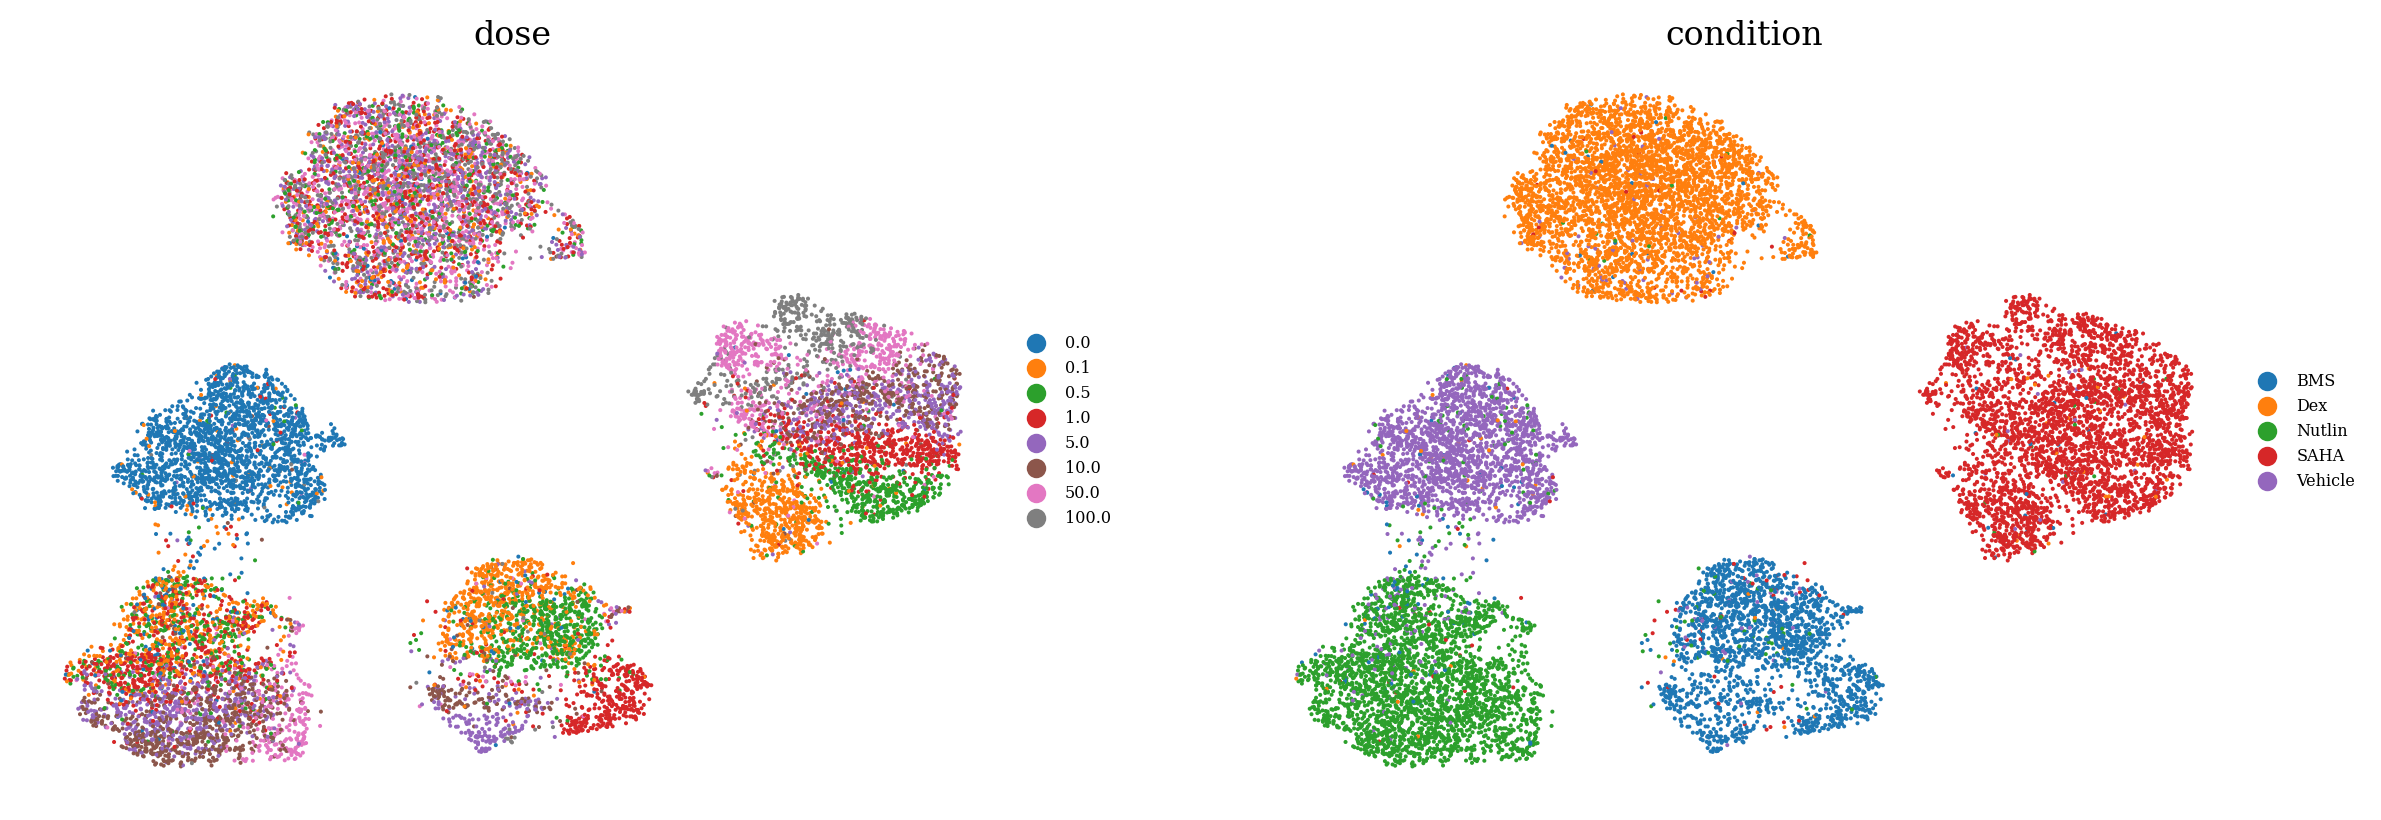

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
from tardis._disentanglementmanager import DisentanglementManager as DM

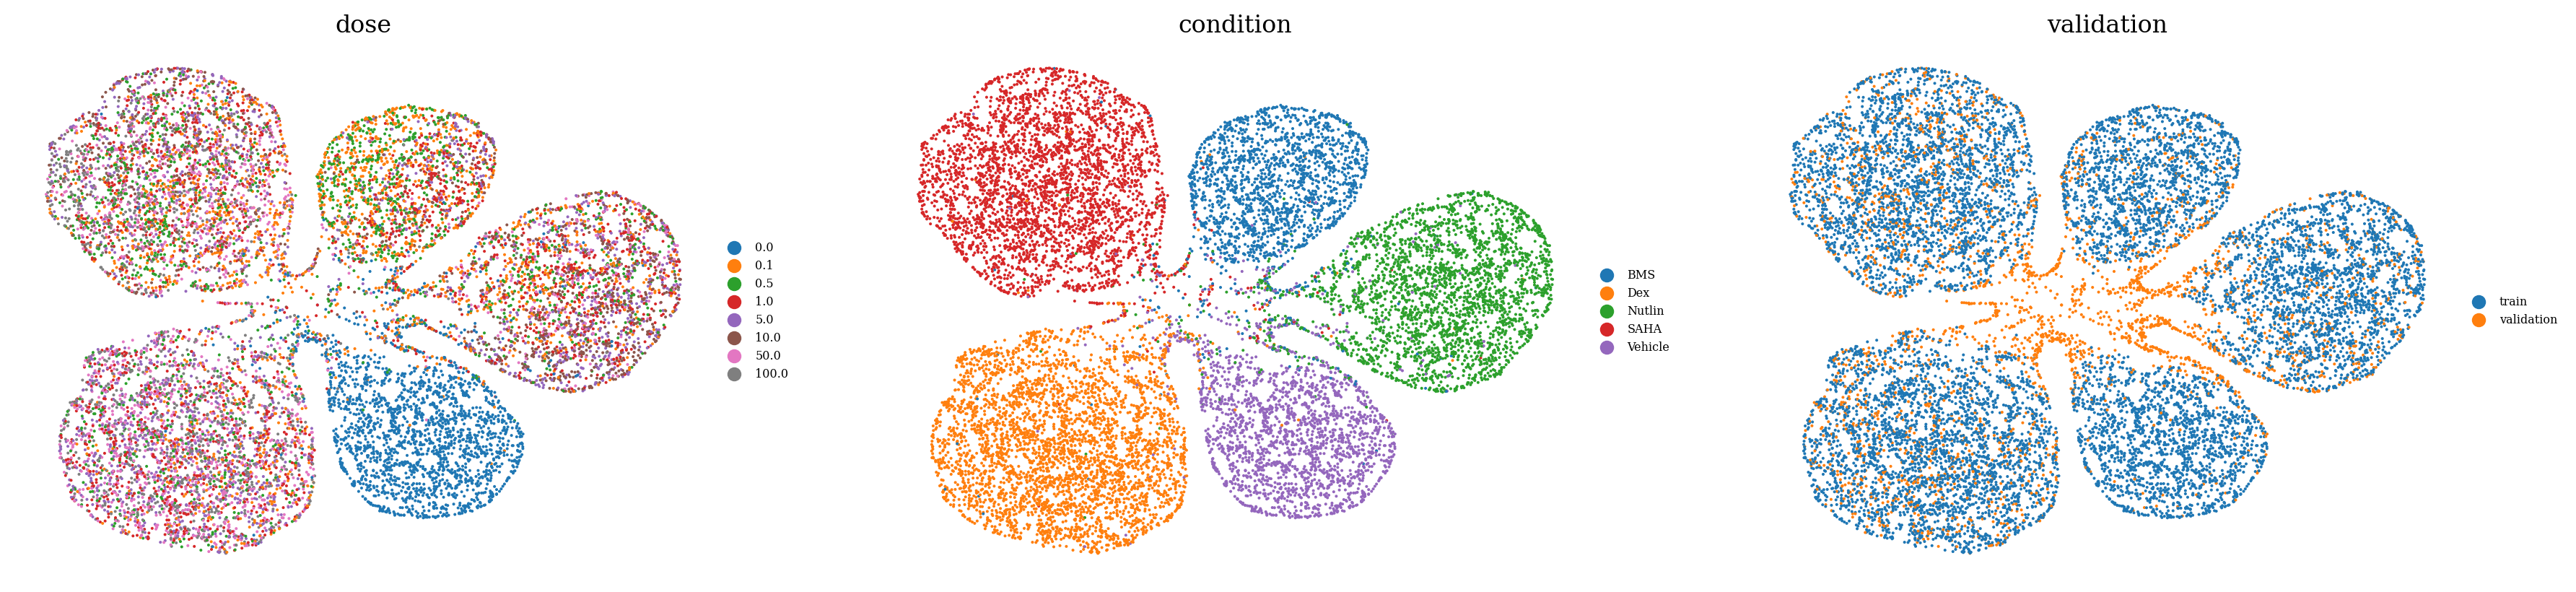

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key(obs_key).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [26]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [27]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


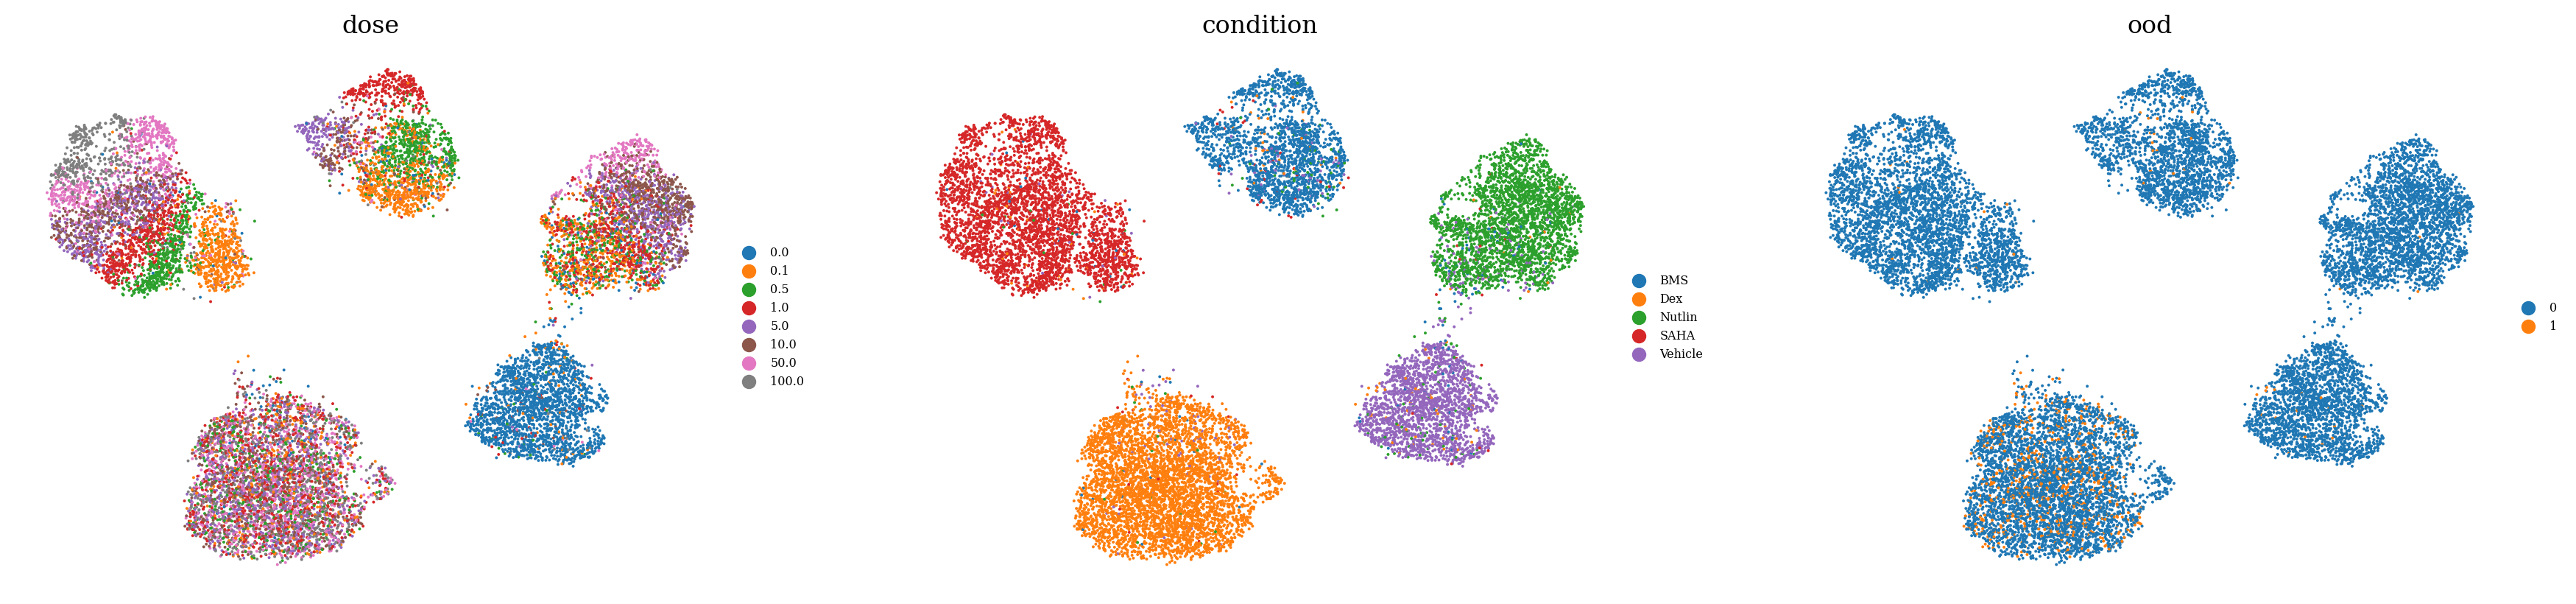

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["dose", "condition", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [29]:
k = obs_key

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


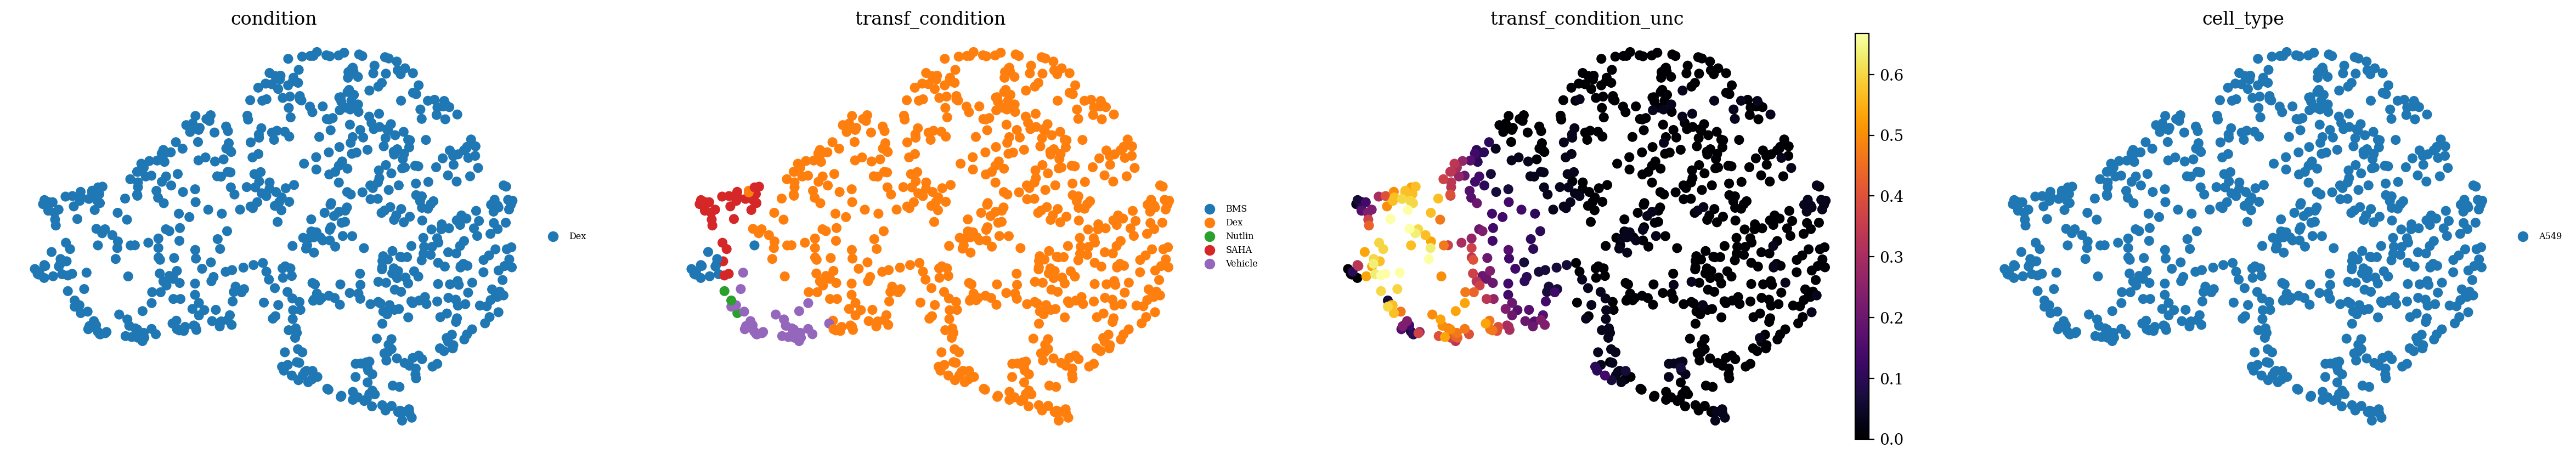

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [31]:
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.8849431818181818,
 'precision_macro': 0.2,
 'recall_macro': 0.17698863636363635,
 'f1_score_macro': 0.18779201205727206,
 'precision_micro': 0.8849431818181818,
 'recall_micro': 0.8849431818181818,
 'f1_score_micro': 0.8849431818181818,
 'precision_weighted': 1.0,
 'recall_weighted': 0.8849431818181818,
 'f1_score_weighted': 0.9389600602863603,
 'confusion_matrix': array([[  0,   0,   0,   0,   0],
        [ 14, 623,   4,  31,  32],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]])}

In [32]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.3016676794274526


In [33]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.21909391668354603
